In this notebook I did an end-to-end machine learning project. I want to divide this section for two classes of readers (technical and non-technical), so everyone can read and digest the important things you need to know in case you don't have the time to evaluate each previous section in detail.

**For non-technical readers:**

The ultimate purpose of a machine learning project is not to get the highest score possible, but to provide the maximum value to the end-user for which it's made. In this project, I show that getting the highest score is for most cases aligns with that purpose, but not in this instance.

The metric that's used to judge the competition this dataset originated from is a metric that I personally think isn't appropriate for the use case of the model, at least not by itself. Optimizing for that metric **alone** leads to the model being able to greatly classify people who will be able to pay their debt while simultaneously not able to predict a big fraction of the risky people. This is alright if what the company wants is a model that coughs up people who are financially just good enough to pay back their debt. Their objective might be to get AS MANY people as they can to apply for a loan and the interests paid by these people will make up for the bad debts.

However, I want to entertain the idea that some companies are greatly more affected by their bad debts, which in turn leads to their preference of NOT accepting potentially bad applications instead of settling and accepting on potentially good applications. For their use case, the model will provide more value if it can identify potentially bad applicants instead of marking 'good-enough' applicants. If you glanced at the modelling sections and the ones after that, you might see that I keep mentioning **precision** and **recalls**. These are technical terms that summarize the tradeoff between marking the two classes of applicants: *identifying as many bad applicants is recall and not misidentifying good applicants is precision*, and balancing the tradeoff between the two is what I tried to do.

**For technical readers:**

This dataset is challenging to handle, which is good since doing a project with a toy dataset will not bring much weight. The major ones are the structure and diverse sources of the data (current application, previous applications at the firm, previous applications at the bureau, etc), the imbalanced nature of the data, and the prevalence of missing values. Here are the list of the major things I did:

- I choose to leave the missing values as it is. A lot of the columns that have missing values are less than a half full and the proper treatment for a column with that many missing values is to drop it, which is unreasonable since it might be an important feature.



- For the imbalanced data, I did not do anything to alter the data. What I did was (very later on) specifying classes weights so that the model is incentivized to be good at predicting the underrepresented positive class.



- In the dataframes other than the main one, each applicant has multiple records of applications and to merge it with the main dataframe, I have to aggregate it by the applicant id. This means for categorical features, the only way to process them is to one-hot encode them and aggregate the mean. For numerical features, what I did was aggregate min, max, sum, mean, and variance for each of the feature. The idea was, I have the processing power for the large number of features and I can weed out the useless ones later. I also created several hand-crafted features that are ratios or differences of the original features. I plan on adding features based on groups (accepted vs unaccepted applications, people which have a certain job and a certain education).



- I went straight to creating a pipeline function that will preprocess all the dataframes so that it'll be easy to preprocess new data for training or prediction. At the end of the pipeline, I reduced the memory usaga of the final dataframe by downcasting each column type to the lowest possible type for each column.



- I also automated most of the EDA by creating two major visualization functions: one for discrete features and one for continuous features. Each function plots the distribution of the feature (bar plot for discrete and kde/violin plot for continuous.)



- I shortlisted Catboost out of XGBoost, LightGBM, and CatBoost, which is three among the few models that can handle missing values.



- The models are optimized to minimize logloss and initially I used ROC-AUC for my metric.



- I create confusion matrices for each of the model and they make the same prediction and mistakes, so no stacking or blending these models.



- The confusion matrices also revealed that the model with the highest score was very bad at identifying the positive class (the bad applicants) and was very good at identifying the negative class (the good applicants). Specifying the 'class_weights' parameter helps the model a lot in this matter while also reduces the ROC-AUC.



- I decided to optimize for the precision/recall of the model. After retraining the model with the class weights specified, with the usual 0.5 threshold for prediction, the model has ~65% recall and ~20% precision. I then plotted the precision-recall curve. The curve has small gradient, so reducing the threshold (at the current state) can give great increase in recall with relatively small decrease in precision. I finally settled at 75% recall with ~17% recall by setting the threshold to ~0.43.



- I choose Bayesian hyperparameter optimization to optimize the model hyperparameters. The method reportedly give better scores than randomsearch or gridsearch. I used hyperopt implementation of the algorithm. For the optimization, I used stratified K-fold for cross-validation during the hyperparameter search.



- Finally, I plotted feature importance and removed 500 features (out of 696 initially) with the model performing virtually as good as it did with 696 features.

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
sns.set(style='dark', palette='hls')
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, precision_recall_curve, f1_score
import xgboost as xgb
import lightgbm as lgbm
import catboost
from catboost.utils import eval_metric, get_confusion_matrix
import re
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin


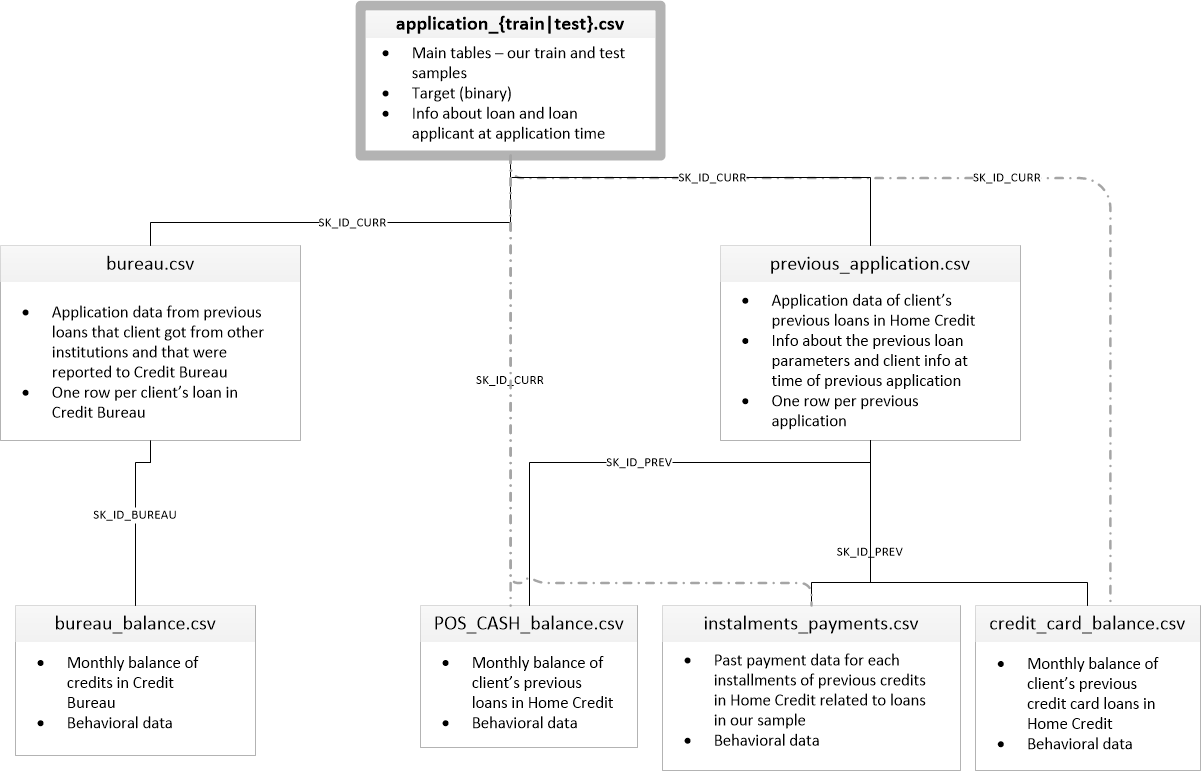

In [2]:
df_main = pd.read_csv('application_train.csv')

# I split application_train into 2 section
# The split is made on the 43th column, which is the last feature before
# the aggregative features (ones ended with AVG, MEDI, MODE) and other features,
# all have (too) many missing values

df_main_compact = df_main.iloc[:, :44]
df_main_rest = df_main.iloc[:, 44:]





# EDA

## Application Train EDA

In [3]:
def features(df):
    f = {i:desc[i] for i in df if i in desc.keys()}
    for i, j in f.items():
        print(i, '  |  ' , j, '\n')

In [4]:
def total_unique_values(df):
    cols = pd.Series(df.columns.values)
    len_unique = pd.Series([len(df[i].unique()) for i in df.columns.values])
    dtype = pd.Series([df[i].dtype for i in df.columns.values])
    unique = pd.concat([cols, len_unique, dtype], axis=1, keys=['Column', 'Total Unique Values', 'Datatype'])
    return unique.sort_values(by='Total Unique Values', ascending=False)

unique = total_unique_values(df_main_compact)


unique

Column  Total Unique Values Datatype
0                    SK_ID_CURR               307511    int64
42                 EXT_SOURCE_2               119832  float64
41                 EXT_SOURCE_1               114585  float64
17                   DAYS_BIRTH                17460    int64
19            DAYS_REGISTRATION                15688  float64
9                   AMT_ANNUITY                13673  float64
18                DAYS_EMPLOYED                12574    int64
20              DAYS_ID_PUBLISH                 6168    int64
8                    AMT_CREDIT                 5603  float64
7              AMT_INCOME_TOTAL                 2548  float64
10              AMT_GOODS_PRICE                 1003  float64
43                 EXT_SOURCE_3                  815  float64
16   REGION_POPULATION_RELATIVE                   81  float64
21                  OWN_CAR_AGE                   63  float64
40            ORGANIZATION_TYPE                   58   object
33      HOUR_APPR_PROCESS_START                   24    int64
28              OCCUPATION_TYPE                   19   object
29              CNT_FAM_MEMBERS                   18  float64
6                  CNT_CHILDREN                   15    int64
12             NAME_INCOME_TYPE                    8   object
11              NAME_TYPE_SUITE                    8   object
32   WEEKDAY_APPR_PROCESS_START                    7   object
14           NAME_FAMILY_STATUS                    6   object
15            NAME_HOUSING_TYPE                    6   object
13          NAME_EDUCATION_TYPE                    5   object
3                   CODE_GENDER                    3   object
30         REGION_RATING_CLIENT                    3    int64
31  REGION_RATING_CLIENT_W_CITY                    3    int64
35   REG_REGION_NOT_WORK_REGION                    2    int64
2            NAME_CONTRACT_TYPE                    2   object
39      LIVE_CITY_NOT_WORK_CITY                    2    int64
38       REG_CITY_NOT_WORK_CITY                    2    int64
37       REG_CITY_NOT_LIVE_CITY                    2    int64
36  LIVE_REGION_NOT_WORK_REGION                    2    int64
4                  FLAG_OWN_CAR                    2   object
34   REG_REGION_NOT_LIVE_REGION                    2    int64
5               FLAG_OWN_REALTY                    2   object
27                   FLAG_EMAIL                    2    int64
26                   FLAG_PHONE                    2    int64
25             FLAG_CONT_MOBILE                    2    int64
24              FLAG_WORK_PHONE                    2    int64
23               FLAG_EMP_PHONE                    2    int64
1                        TARGET                    2    int64
22                   FLAG_MOBIL                    2    int64

Descriptive Statistics

In [5]:
cat_cols = unique.loc[unique['Total Unique Values'] <= 58]['Column'].values.tolist()
cont_cols = [i for i in df_main_compact.columns if i not in cat_cols + ['SK_ID_CURR']]


def stats(df, cols):
    stats = df[cols].describe()
    return stats.transpose().applymap(lambda x: round(x, 3))
    #return stats.transpose().style.bar(subset=[i for i in stats.transpose().columns if i != 'count'], color='orange', axis=1)

stats(df_main_compact, cont_cols)

count        mean         std        min  \
AMT_INCOME_TOTAL            307511.0  168797.919  237123.146  25650.000   
AMT_CREDIT                  307511.0  599026.000  402490.777  45000.000   
AMT_ANNUITY                 307499.0   27108.574   14493.737   1615.500   
AMT_GOODS_PRICE             307233.0  538396.207  369446.461  40500.000   
REGION_POPULATION_RELATIVE  307511.0       0.021       0.014      0.000   
DAYS_BIRTH                  307511.0  -16036.995    4363.989 -25229.000   
DAYS_EMPLOYED               307511.0   63815.046  141275.767 -17912.000   
DAYS_REGISTRATION           307511.0   -4986.120    3522.886 -24672.000   
DAYS_ID_PUBLISH             307511.0   -2994.202    1509.450  -7197.000   
OWN_CAR_AGE                 104582.0      12.061      11.945      0.000   
EXT_SOURCE_1                134133.0       0.502       0.211      0.015   
EXT_SOURCE_2                306851.0       0.514       0.191      0.000   
EXT_SOURCE_3                246546.0       0.511       0.195      0.001   

                                   25%         50%         75%           max  
AMT_INCOME_TOTAL            112500.000  147150.000  202500.000  1.170000e+08  
AMT_CREDIT                  270000.000  513531.000  808650.000  4.050000e+06  
AMT_ANNUITY                  16524.000   24903.000   34596.000  2.580255e+05  
AMT_GOODS_PRICE             238500.000  450000.000  679500.000  4.050000e+06  
REGION_POPULATION_RELATIVE       0.010       0.019       0.029  7.300000e-02  
DAYS_BIRTH                  -19682.000  -15750.000  -12413.000 -7.489000e+03  
DAYS_EMPLOYED                -2760.000   -1213.000    -289.000  3.652430e+05  
DAYS_REGISTRATION            -7479.500   -4504.000   -2010.000  0.000000e+00  
DAYS_ID_PUBLISH              -4299.000   -3254.000   -1720.000  0.000000e+00  
OWN_CAR_AGE                      5.000       9.000      15.000  9.100000e+01  
EXT_SOURCE_1                     0.334       0.506       0.675  9.630000e-01  
EXT_SOURCE_2                     0.392       0.566       0.664  8.550000e-01  
EXT_SOURCE_3                     0.371       0.535       0.669  8.960000e-01

In [6]:
desc_ = pd.read_csv('HomeCredit_columns_description_.csv', encoding = "ISO-8859-1")

desc = {i:j for i, j in zip(desc_['Row'].values.tolist(), desc_['Description'].values.tolist())}

main_cols = df_main.columns.to_list()
C = df_main_compact.columns.to_list()
C_ = {i:desc[i] for i in C}

pf = {}

Missing Values


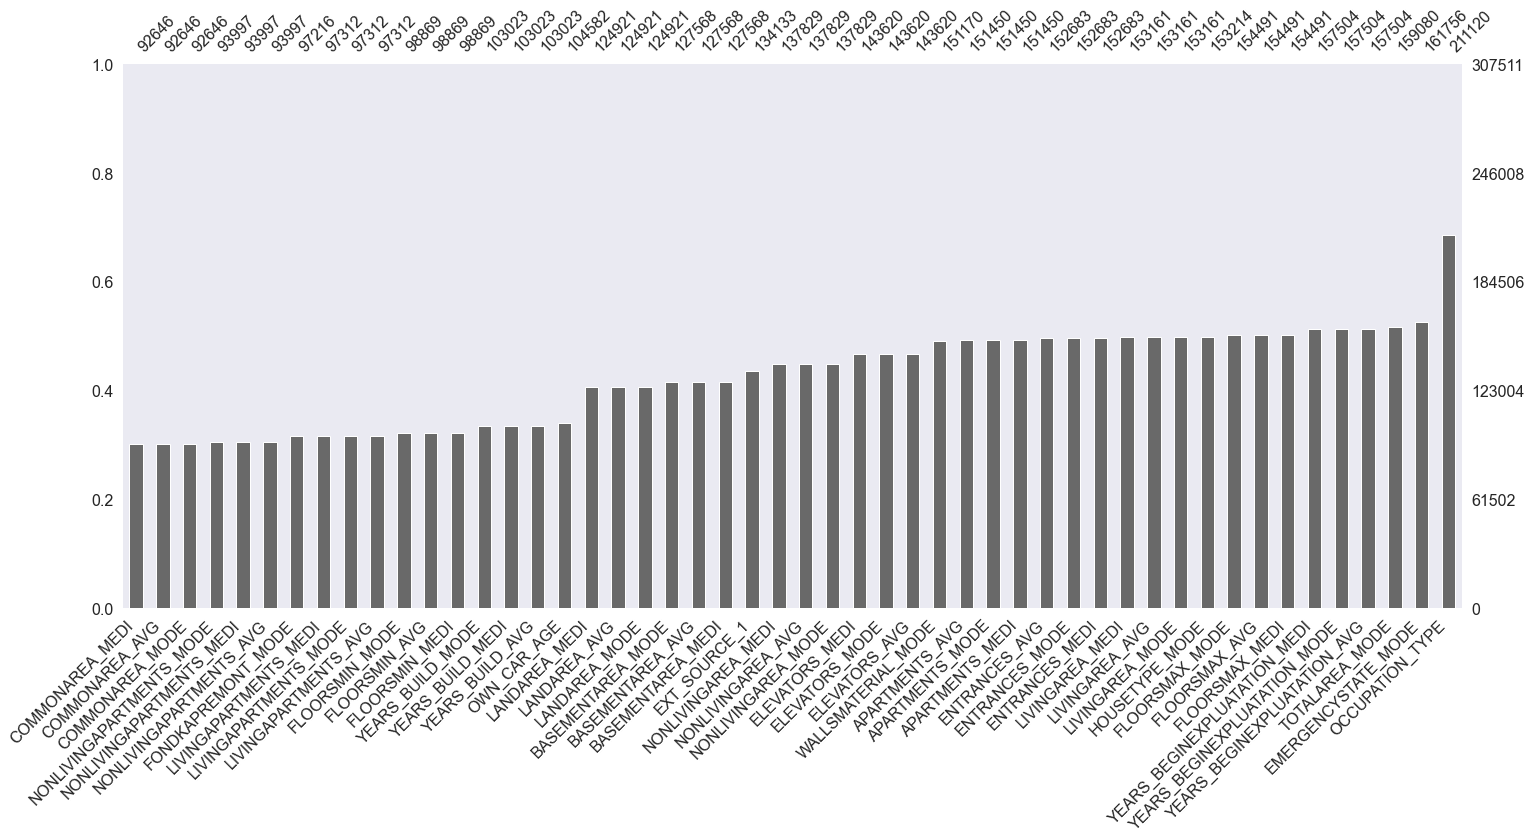

In [121]:
print('Missing Values')
msno.bar(df_main, filter='bottom', n=50, sort='ascending')

Missing Values


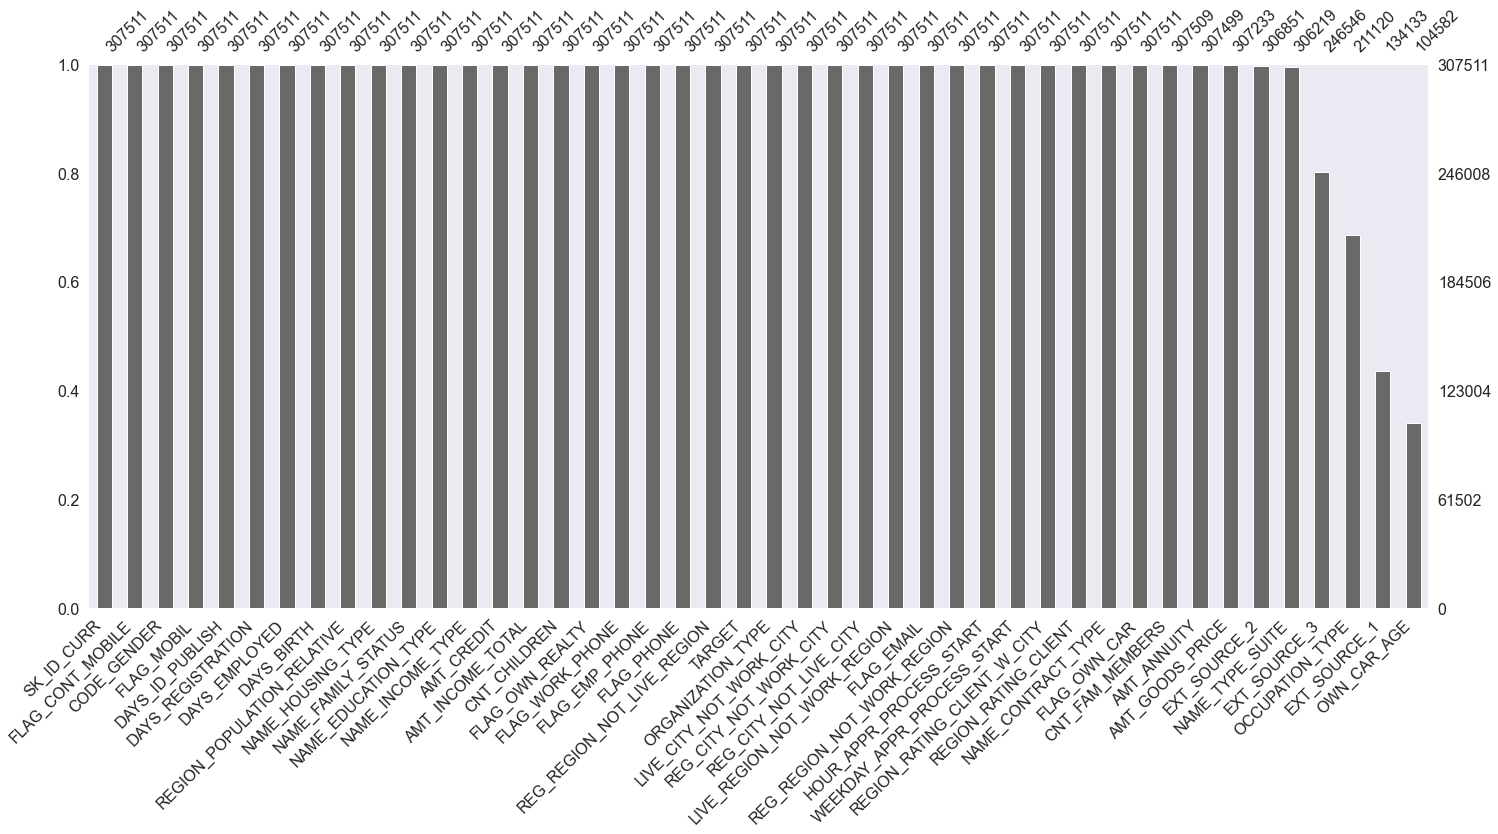

In [122]:
print('Missing Values')
msno.bar(df_main_compact, sort='descending')

Missing Values


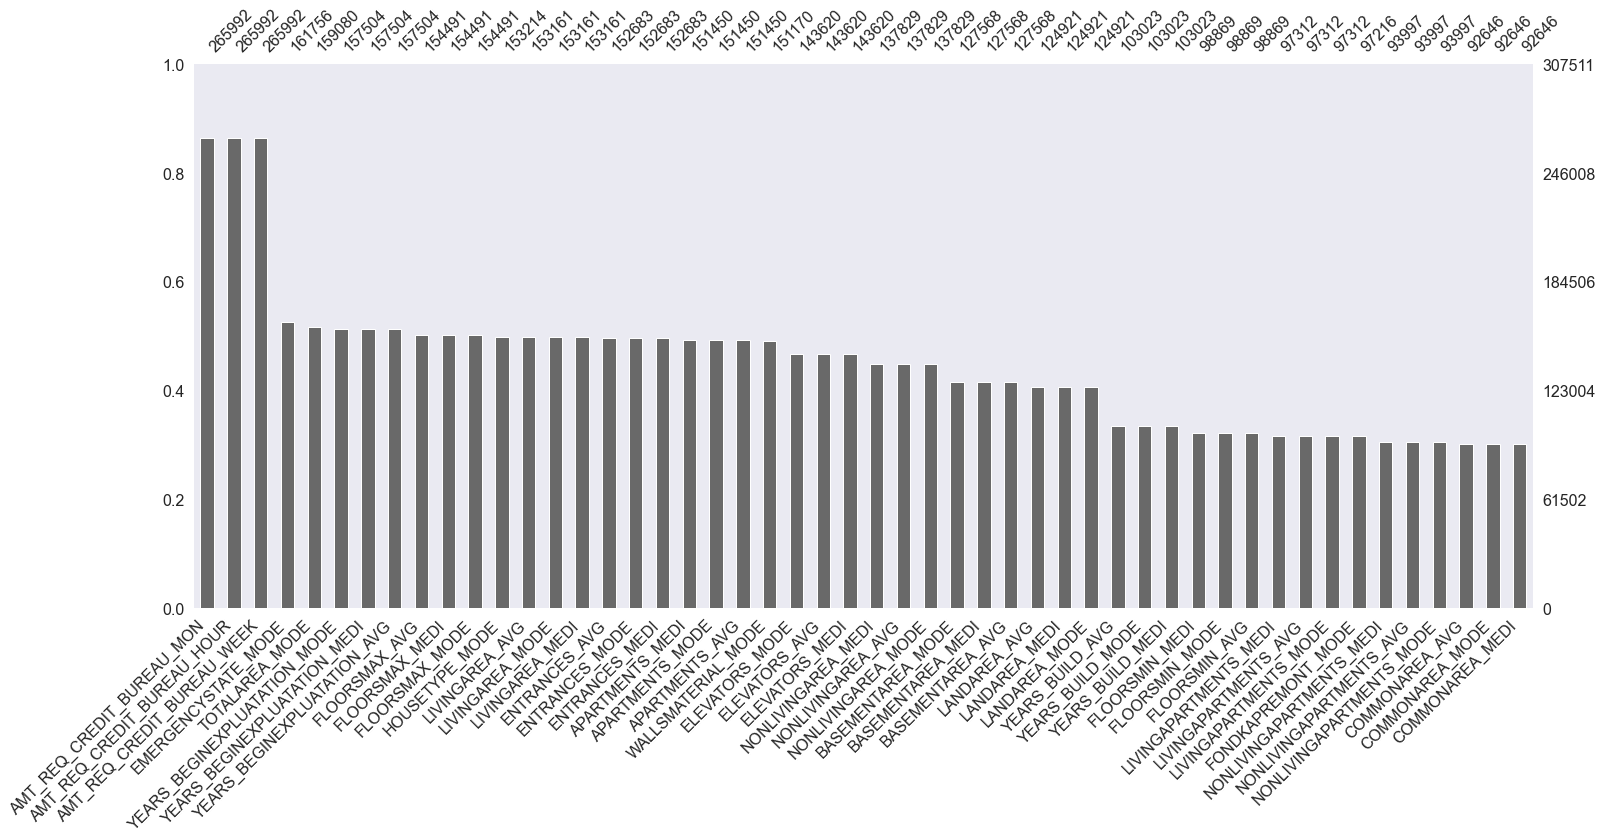

In [123]:
print('Missing Values')
msno.bar(df_main_rest, sort='descending', filter='bottom', n=50)

Text(0.5, 1.0, 'Proportion of missing value (TARGET = 1)')

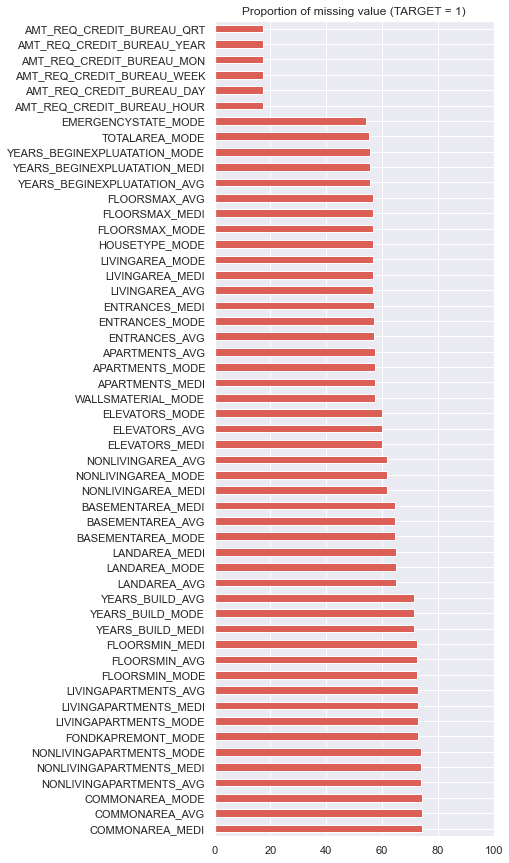

In [124]:
miss = df_main_rest.isnull().sum()
col_miss = miss.sort_values(ascending=False)[:53].index.tolist()
cols = col_miss + ['TARGET']
tmp = df_main[cols]

d = {}
for i in cols[:-1]:
    len_miss = tmp.loc[(tmp['TARGET'] == 1) & (tmp[i].isnull())].shape[0]
    d[i] = [len_miss/tmp.loc[tmp['TARGET'] == 1].shape[0]]

    
dff = pd.DataFrame(d).transpose()
dff[0] = dff.apply(lambda x: x*100)
ax = dff.plot(kind='barh', legend=False, figsize=(5, 15), grid=True)
ax.set_xlim(0, 100)
ax.set_title('Proportion of missing value (TARGET = 1)')

In [98]:
df_main_compact['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

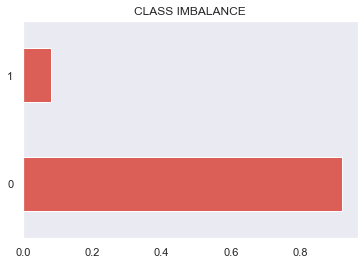

In [125]:
df_main_compact['TARGET'].value_counts(normalize=True).plot(kind='barh', title='CLASS IMBALANCE')

In [7]:
# A really efficient function to plot both a variable's category composition and each category's correlation
# with the target variable (default or not default)
# Adapted from https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda
# Changes I made: 1) I added the title for each subplot 2) I make the y-axis range on the second subplot
# fixed to not make any small difference in percentage too dramatic

def plot_stats(feature, df, print_description=False, h=True, label_rotation=False, add_width=0, title=''):
    tmp = df.copy()
    if print_description:
        print(desc[feature])
    temp = tmp[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    df1[feature]  = df1[feature].apply(lambda x: str(x))

    # Calculate the percentage of target=1 per category value
    cat_perc = tmp[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    cat_perc['TARGET'] = cat_perc['TARGET'].apply(lambda x: x*100)
    
    if(h):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12 + add_width,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12 + add_width,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=45, ha='right')
    for i, v in enumerate(df1['Number of contracts'].values):
        ax1.text(i, v + max(df1['Number of contracts'].values) * 0.01, "%d" %v, ha="center")
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=45, ha='right')
    for i, v in enumerate(cat_perc['TARGET'].values):
        ax2.text(i, v+2, "%d" %v, ha="center")
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    ax1.set_title('Count')
    ax2.set_title('Percentage of default')
    ax2.set_ylim(0, 100)
    plt.tight_layout()

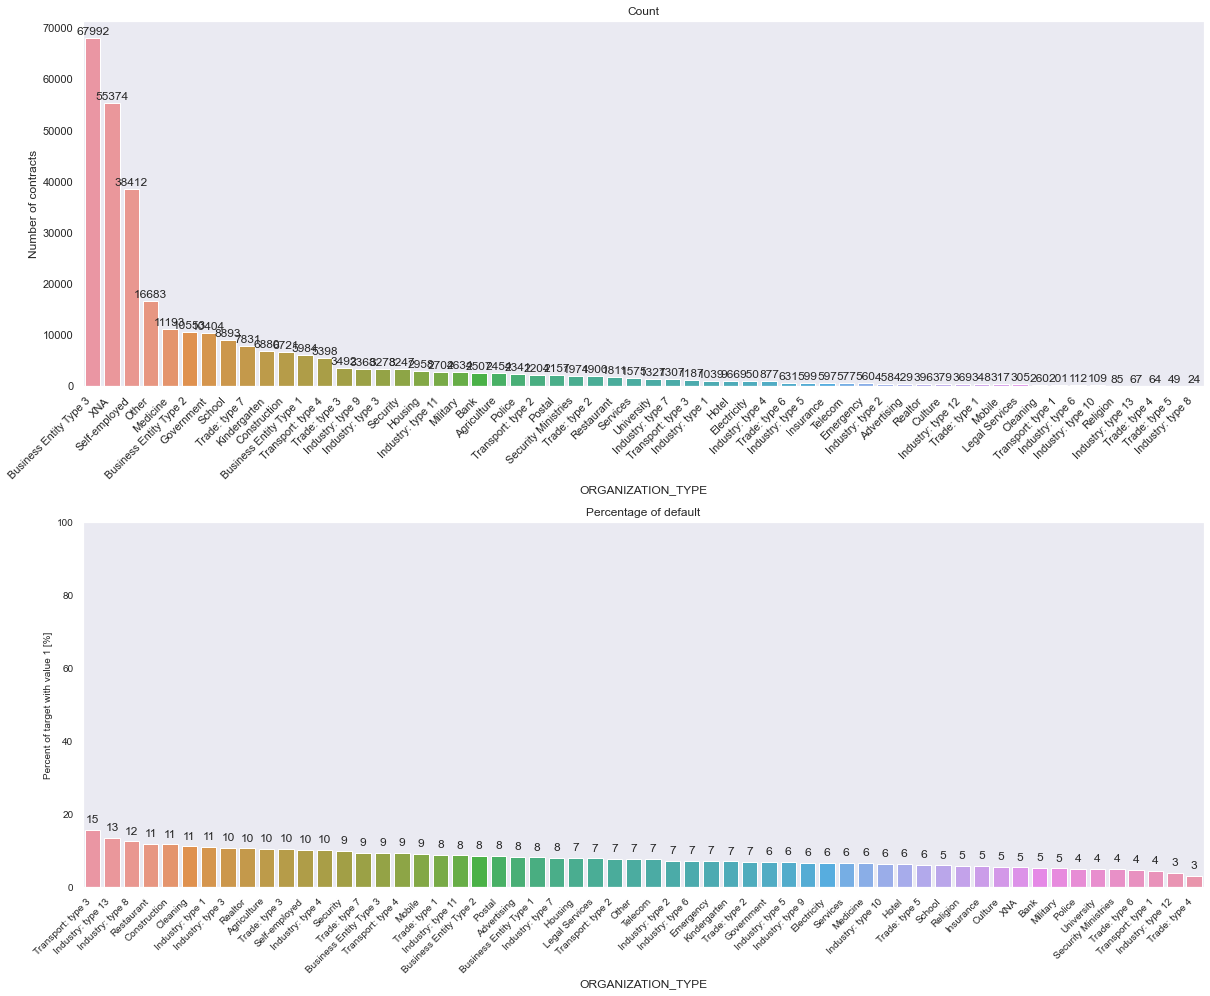

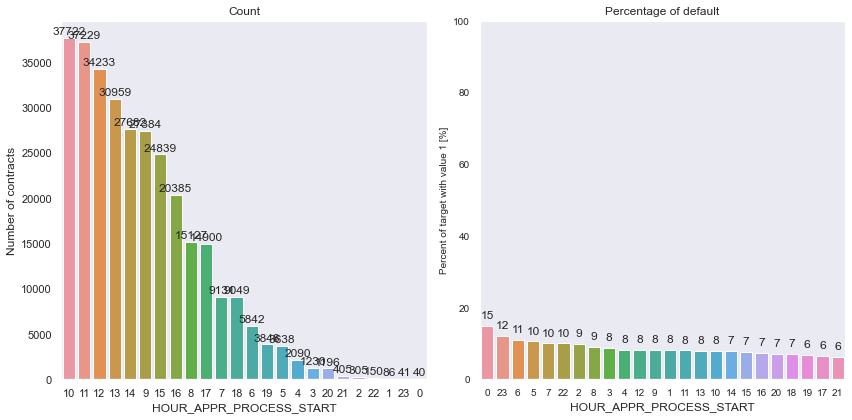

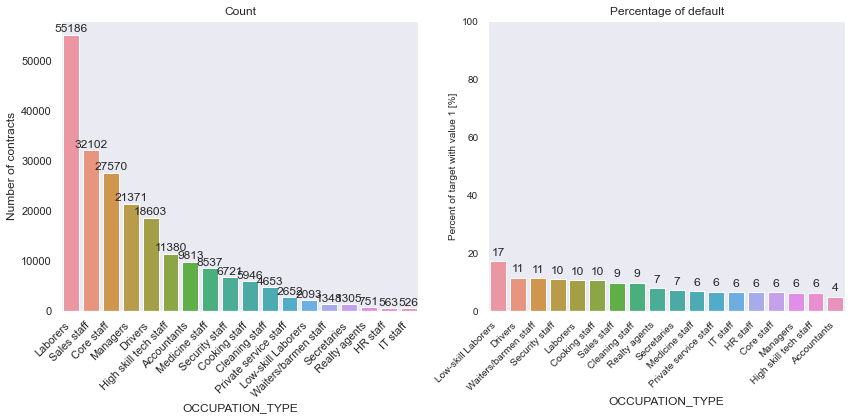

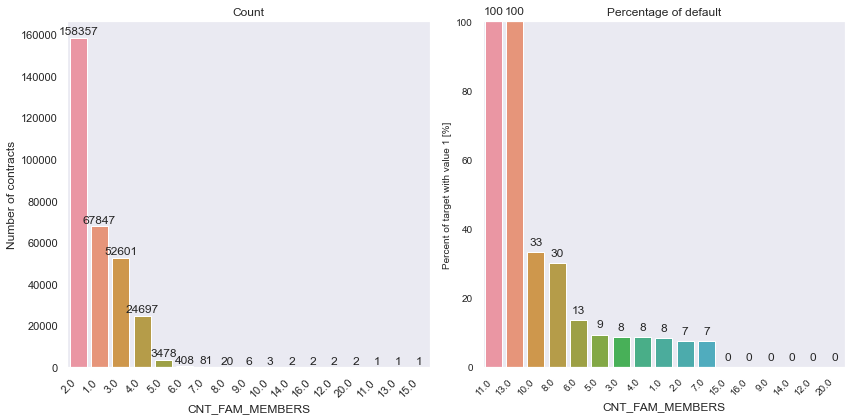

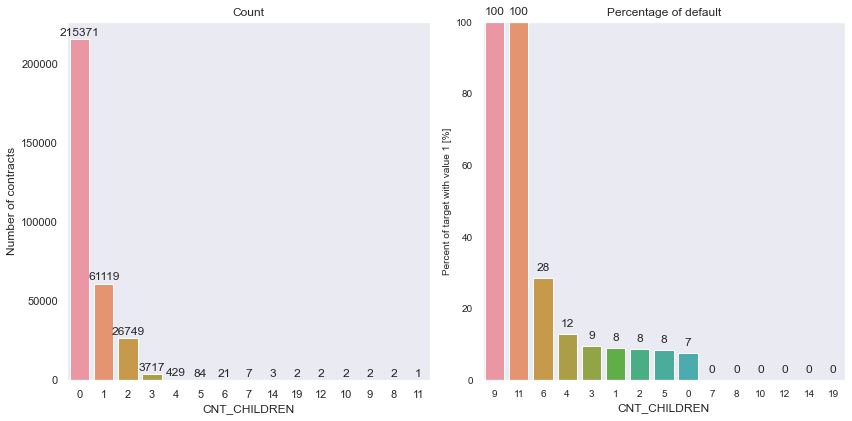

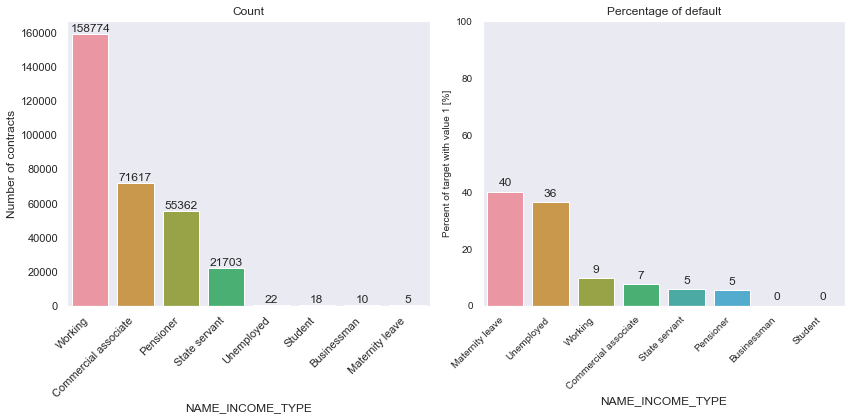

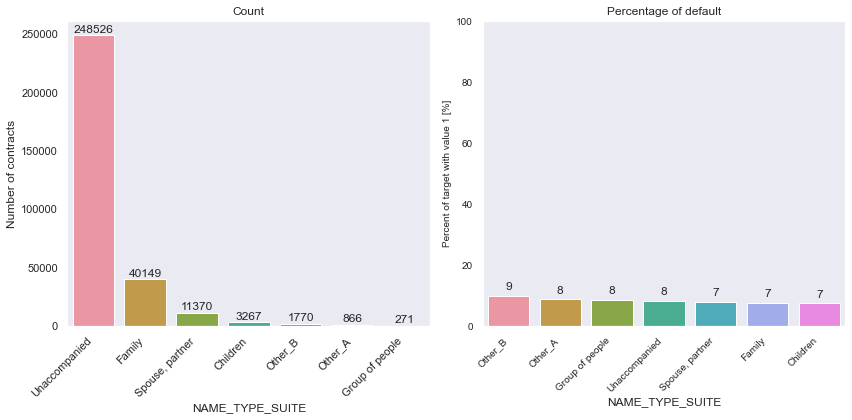

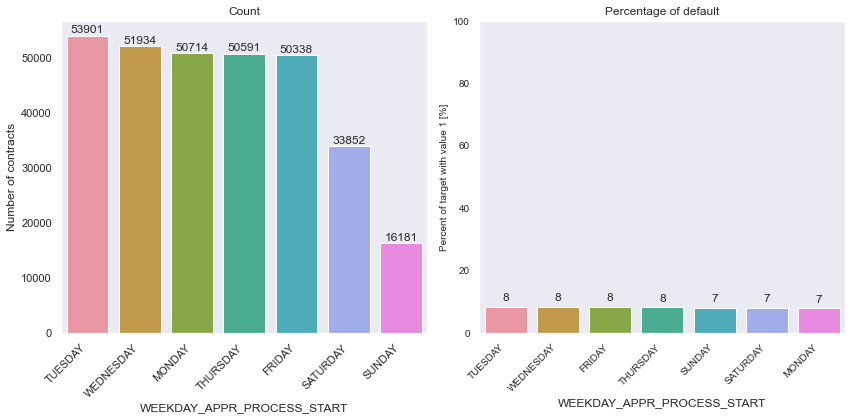

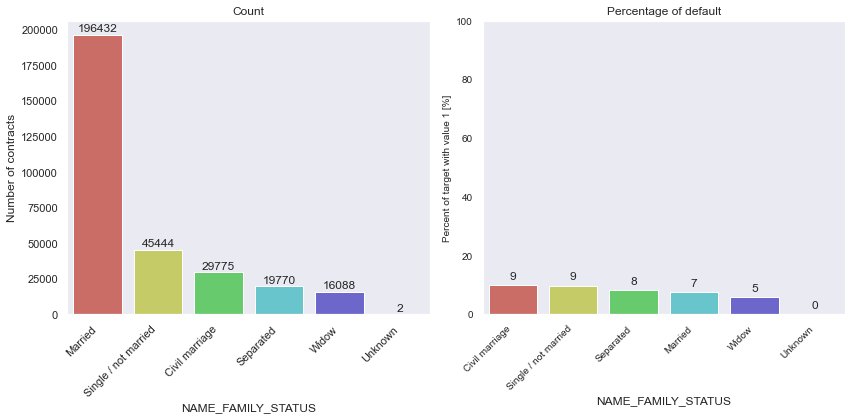

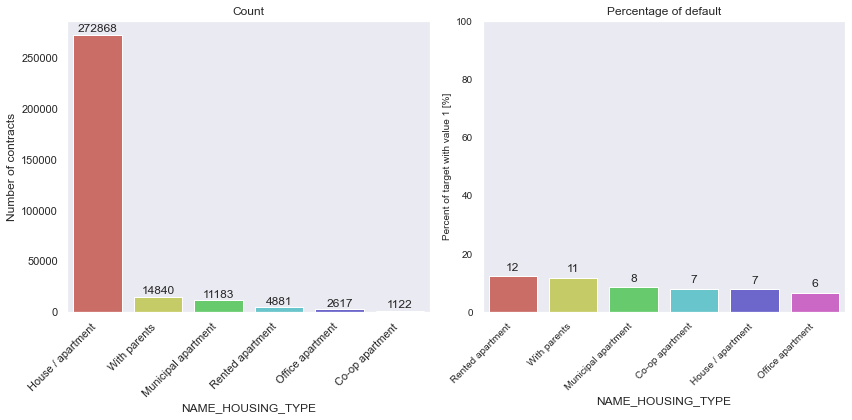

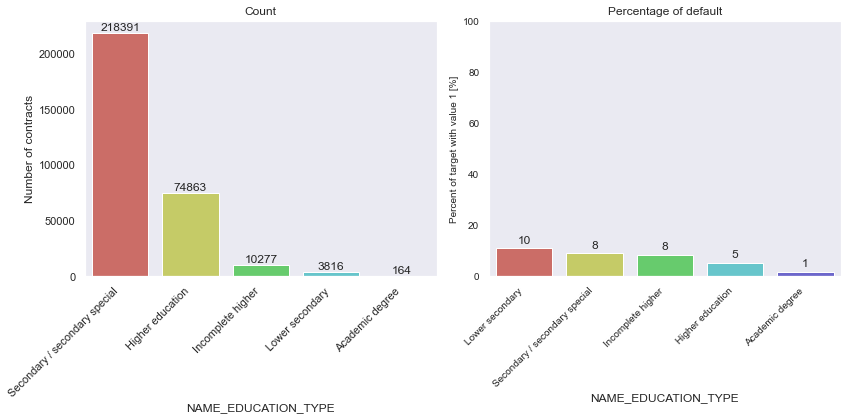

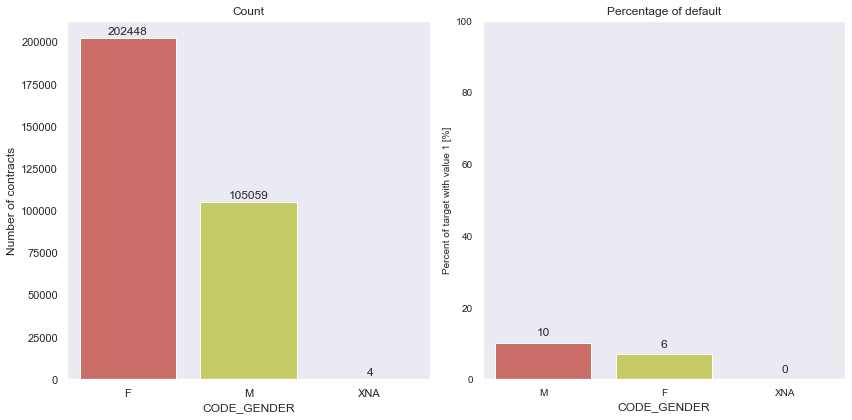

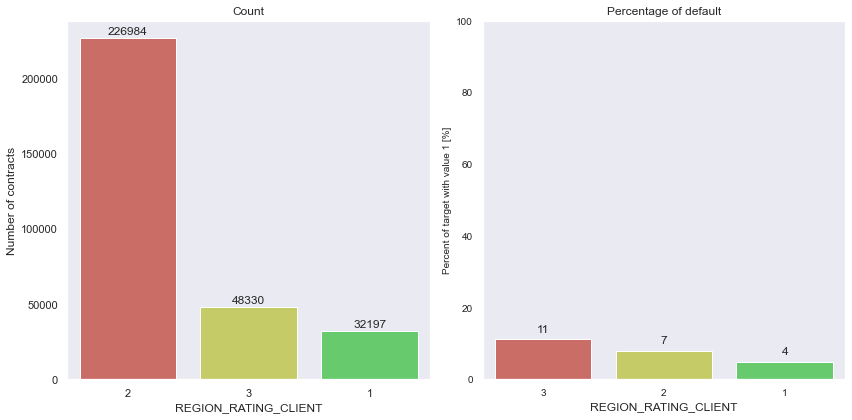

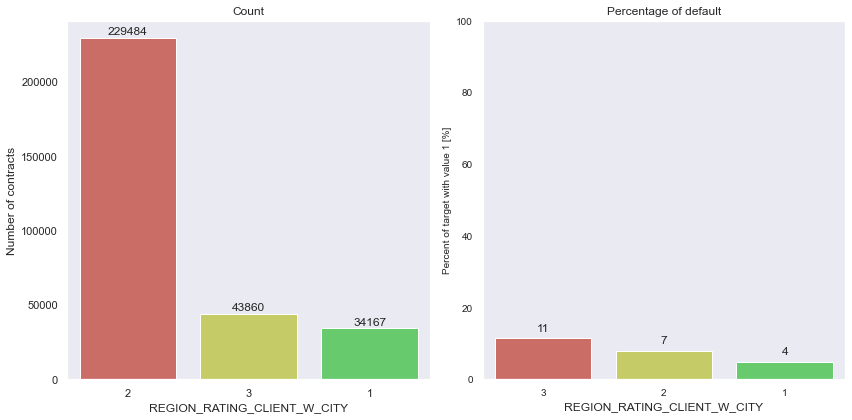

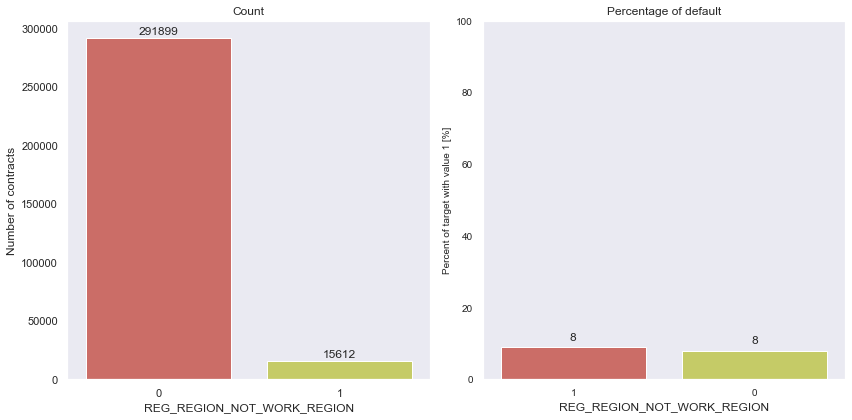

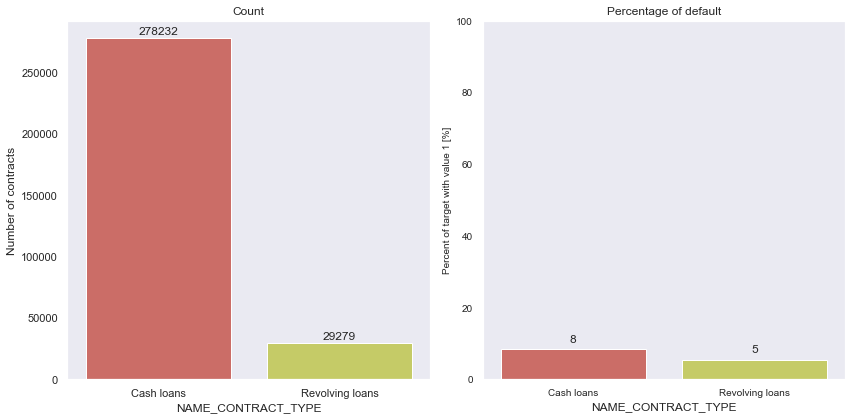

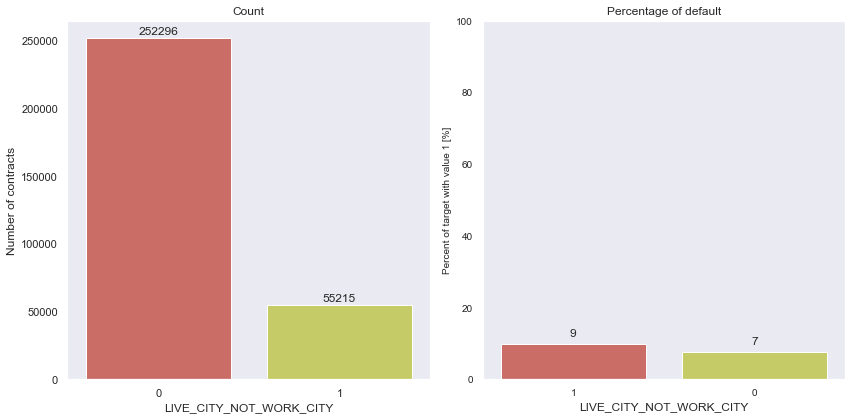

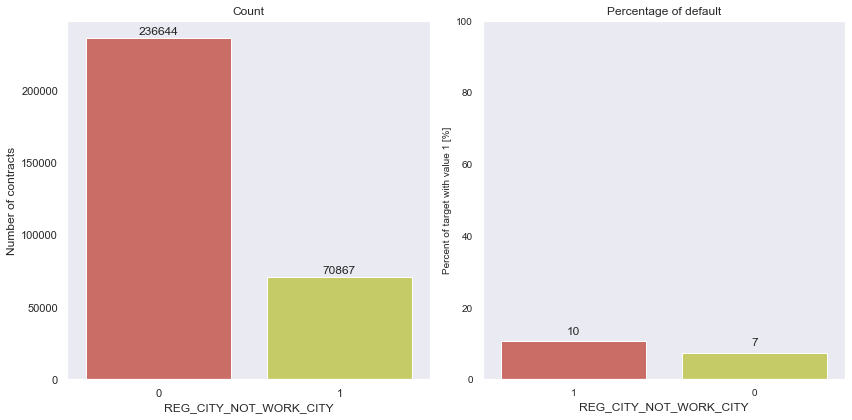

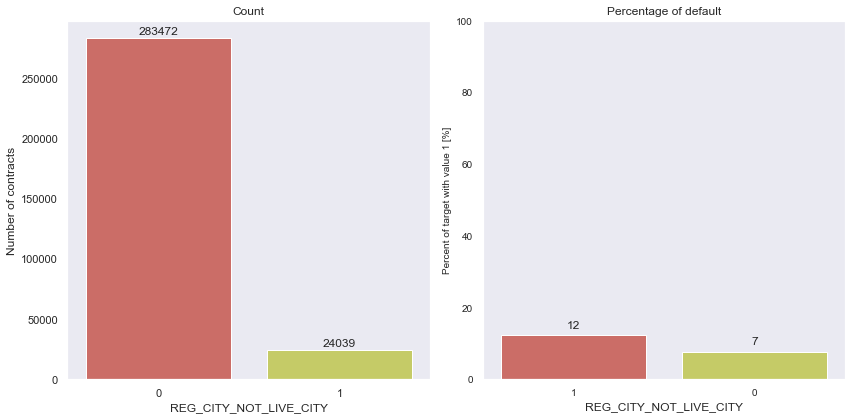

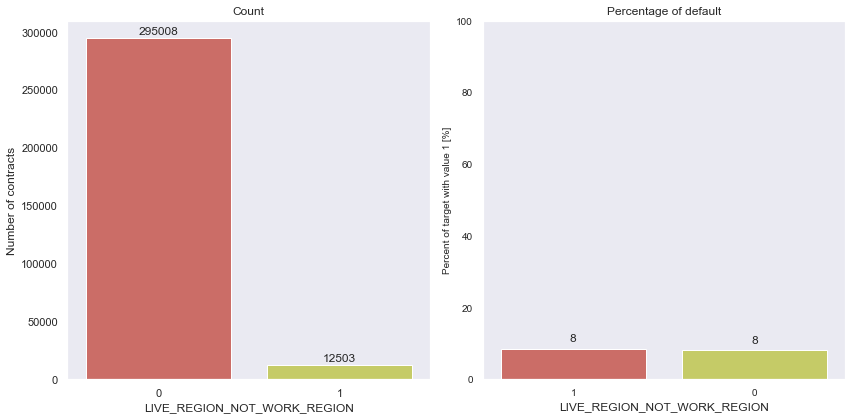

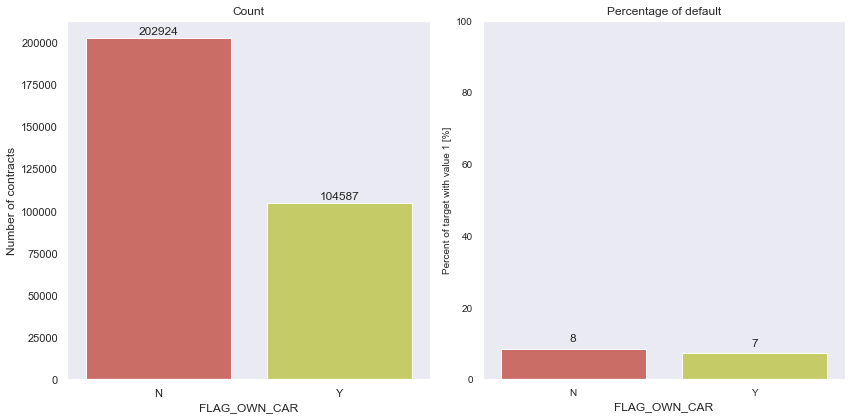

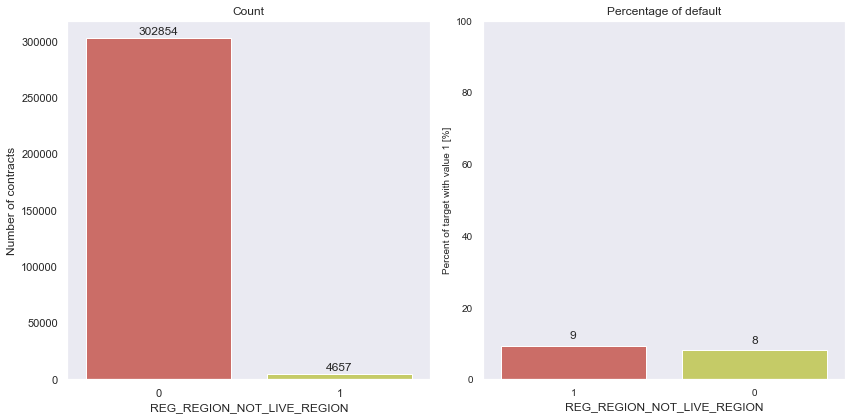

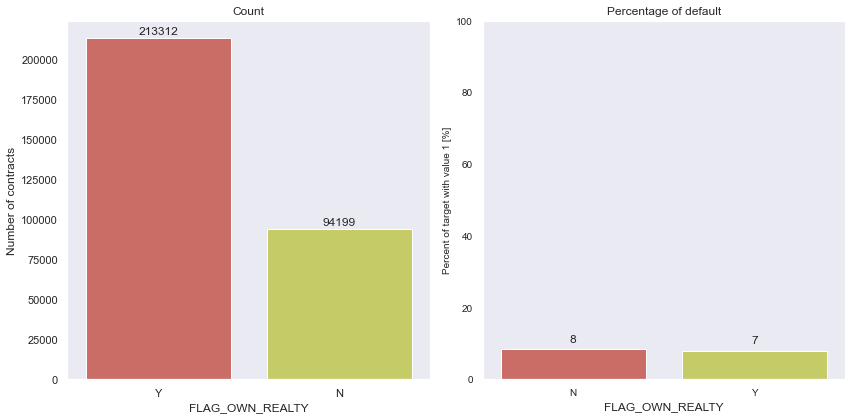

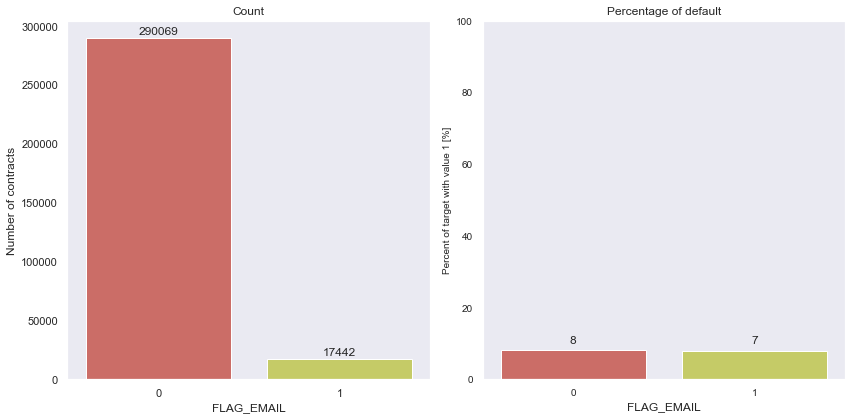

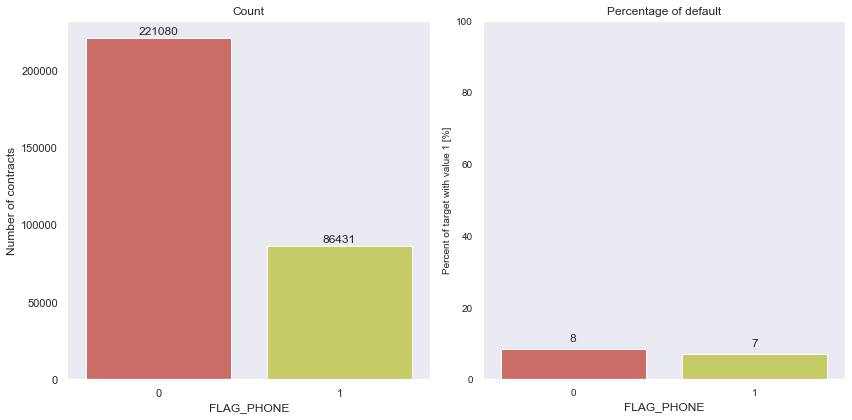

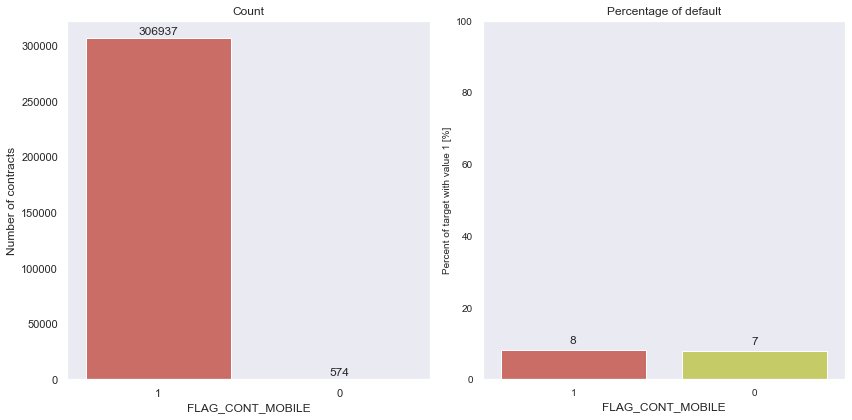

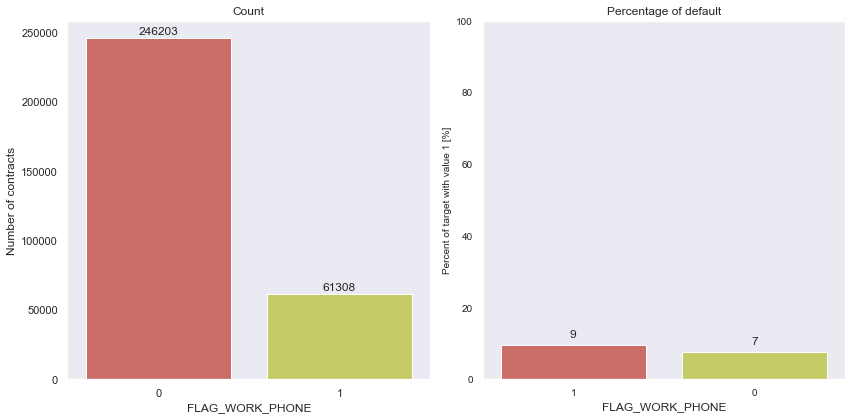

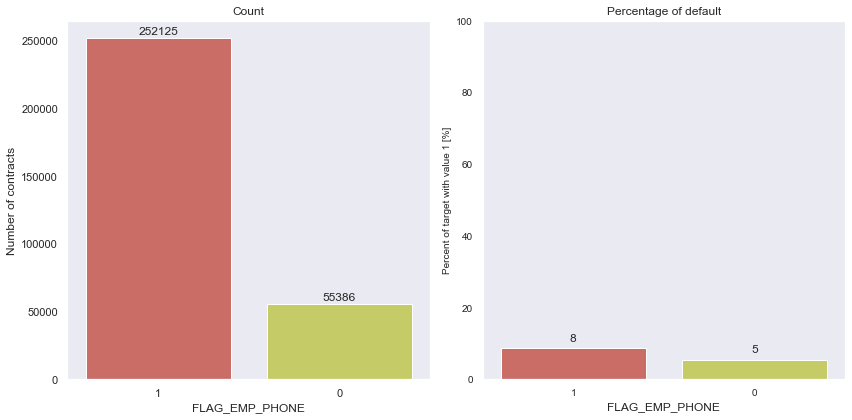

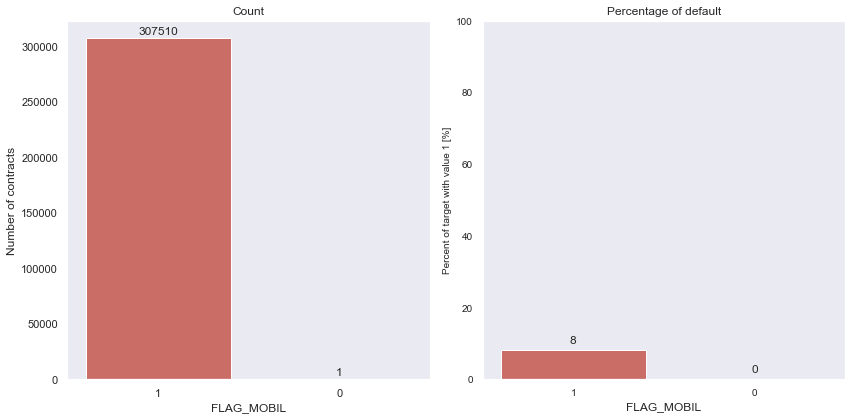

In [127]:
cols = [i for i in cat_cols if i != 'TARGET']

rotate = [i for i in range(0, 11) if i not in [1, 4]]

for i, j in enumerate(cols):
    rotate_ = True if i in rotate else False
    horizontal = False if i == 0 else True
    width = 5 if i == 0 else 0
    plot_stats(j, df_main_compact, label_rotation=rotate_, h=horizontal, add_width=width)

In [8]:
def plot_stats_cont(var, print_description=False, log=False, title='', custom_df=None):
    if print_description:
        print(desc[var])
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    s = sns.kdeplot(data=custom_df if custom_df is not None else df_main_compact, x=var, ax=ax1)
    s = sns.violinplot(data=custom_df if custom_df is not None else df_main_compact, y=var, x='TARGET', ax=ax2)
    plt.title(title)
    plt.tight_layout()
    if log:
        ax2.set_yscale('log')

In [129]:
def last_n(df, col, n):
    return df[col].value_counts().sort_index()[-n:]


In [130]:
desc['AMT_CREDIT']

'Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT'

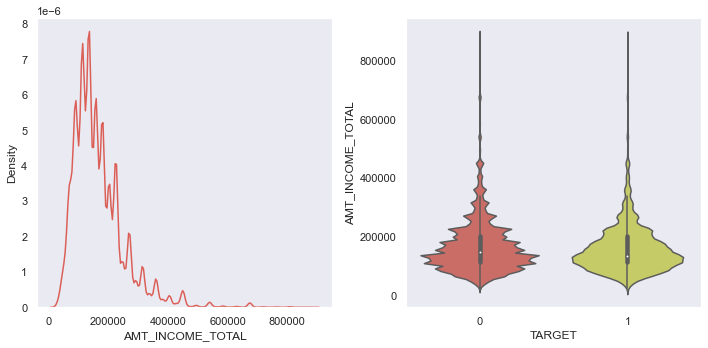

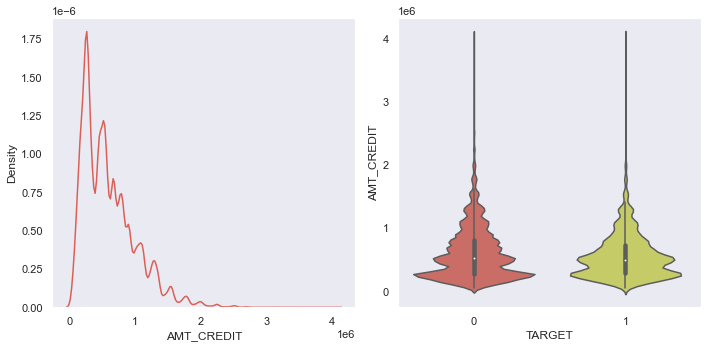

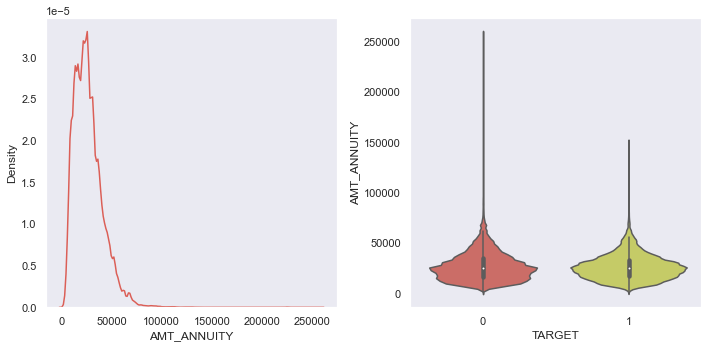

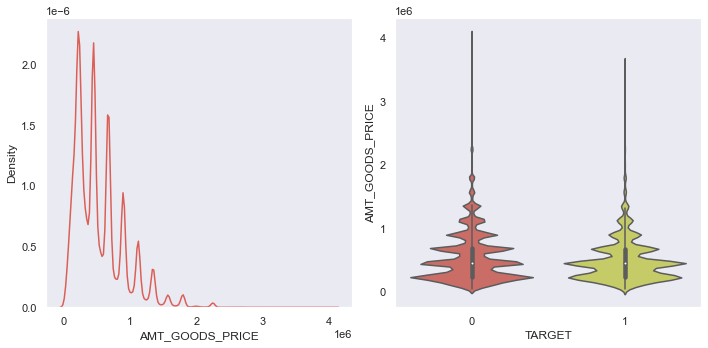

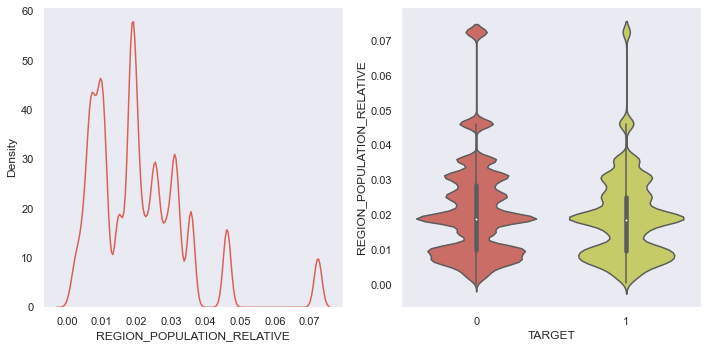

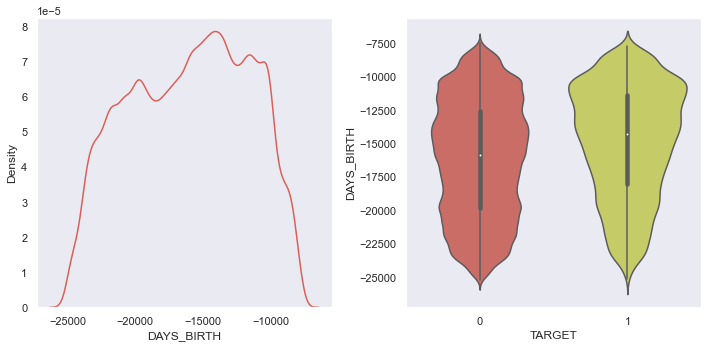

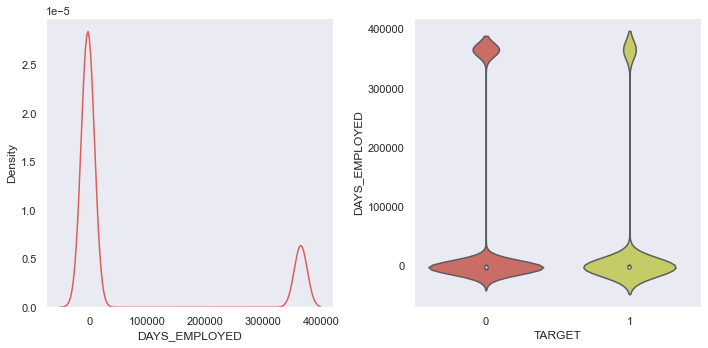

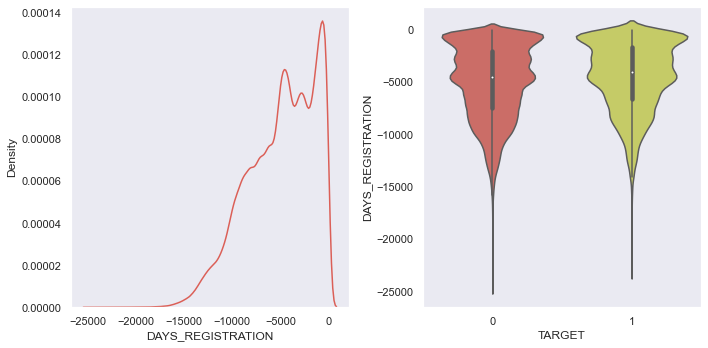

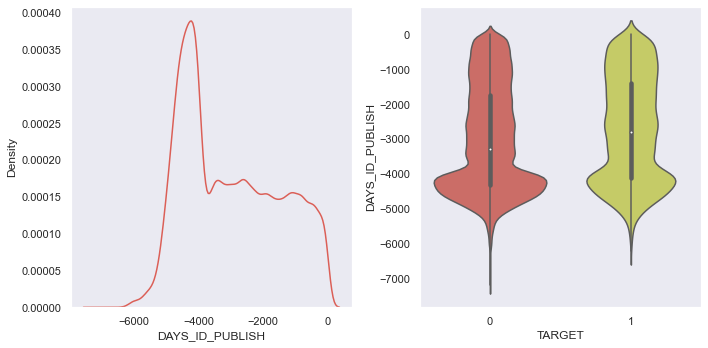

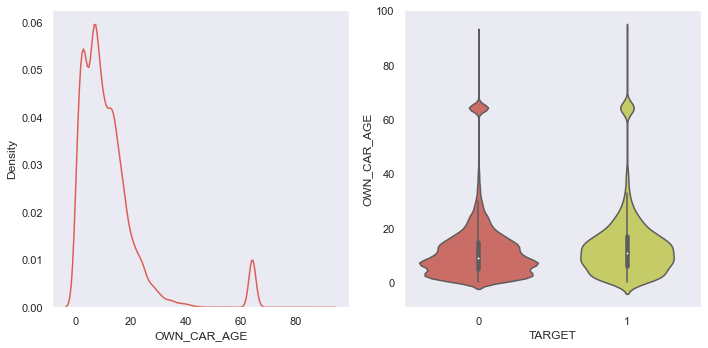

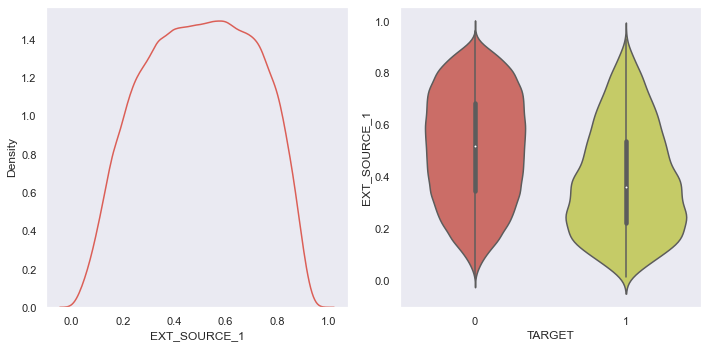

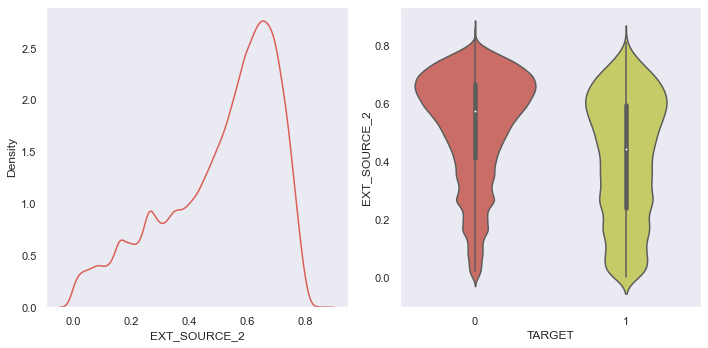

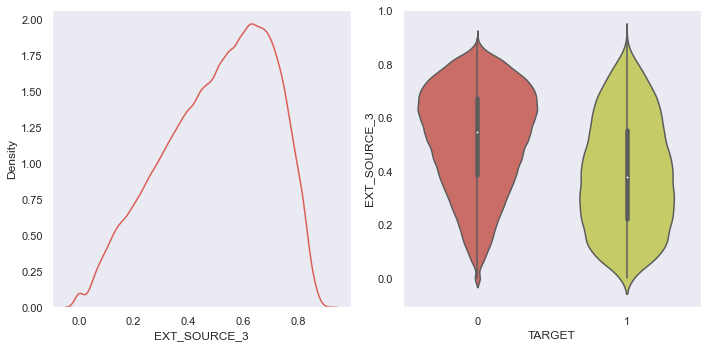

In [131]:
cust = df_main_compact.loc[df_main_compact['AMT_INCOME_TOTAL'] < np.percentile(df_main_compact['AMT_INCOME_TOTAL'], 99.9)]

for i, j in enumerate(cont_cols):
    plot_stats_cont(j, custom_df = cust if i == 0 else None)

## Previous Application (EDA)

In [9]:
df_prev = pd.read_csv('previous_application.csv')

In [133]:
df_prev.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [10]:
desc_prev = {i: desc[i] for i in df_prev.columns[1:]}

In [135]:
df_prev.shape

(1670214, 37)

In [136]:
a = df_prev['SK_ID_CURR'].value_counts()
b = [i for i in a.values if i != 1]
print(len(b), 'applicants have applied more than once.')

278399 applicants have applied more than once.


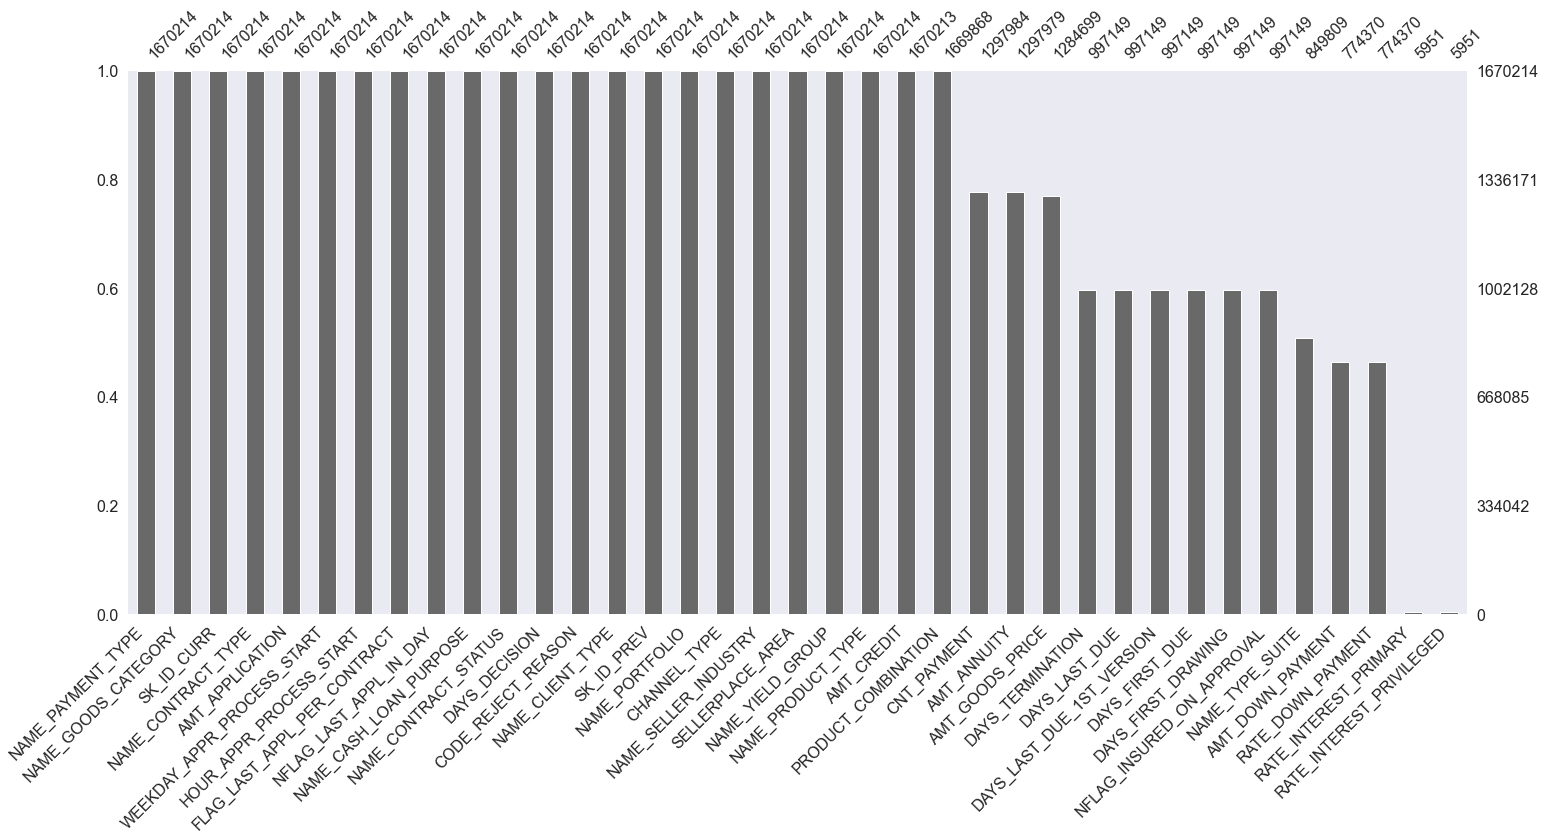

In [137]:
msno.bar(df_prev, sort='descending')

In [138]:
df_prev.shape

(1670214, 37)

In [11]:
unique = total_unique_values(df_prev)
unique

Column  Total Unique Values Datatype
0                    SK_ID_PREV              1670214    int64
3                   AMT_ANNUITY               357960  float64
1                    SK_ID_CURR               338857    int64
12            RATE_DOWN_PAYMENT               207034  float64
7               AMT_GOODS_PRICE                93886  float64
4               AMT_APPLICATION                93885  float64
5                    AMT_CREDIT                86804  float64
6              AMT_DOWN_PAYMENT                29279  float64
33    DAYS_LAST_DUE_1ST_VERSION                 4606  float64
17                DAYS_DECISION                 2922    int64
32               DAYS_FIRST_DUE                 2893  float64
34                DAYS_LAST_DUE                 2874  float64
31           DAYS_FIRST_DRAWING                 2839  float64
35             DAYS_TERMINATION                 2831  float64
26             SELLERPLACE_AREA                 2097    int64
13        RATE_INTEREST_PRIMARY                  149  float64
28                  CNT_PAYMENT                   50  float64
22          NAME_GOODS_CATEGORY                   28   object
14     RATE_INTEREST_PRIVILEGED                   26  float64
15       NAME_CASH_LOAN_PURPOSE                   25   object
9       HOUR_APPR_PROCESS_START                   24    int64
30          PRODUCT_COMBINATION                   18   object
27         NAME_SELLER_INDUSTRY                   11   object
19           CODE_REJECT_REASON                    9   object
20              NAME_TYPE_SUITE                    8   object
25                 CHANNEL_TYPE                    8   object
8    WEEKDAY_APPR_PROCESS_START                    7   object
29             NAME_YIELD_GROUP                    5   object
23               NAME_PORTFOLIO                    5   object
18            NAME_PAYMENT_TYPE                    4   object
21             NAME_CLIENT_TYPE                    4   object
16         NAME_CONTRACT_STATUS                    4   object
2            NAME_CONTRACT_TYPE                    4   object
24            NAME_PRODUCT_TYPE                    3   object
36    NFLAG_INSURED_ON_APPROVAL                    3  float64
11       NFLAG_LAST_APPL_IN_DAY                    2    int64
10  FLAG_LAST_APPL_PER_CONTRACT                    2   object

In [12]:
df_prev_mrg = df_prev.merge(df_main_compact[['TARGET', 'SK_ID_CURR']], on='SK_ID_CURR', how='right')
cat_cols = unique.loc[unique['Total Unique Values'] <= 50, 'Column'].values.tolist()
cat_cols = [i for i in cat_cols if i not in ['CNT_PAYMENT', 'RATE_INTEREST_PRIVILEGED']]
cont_cols = [i for i in df_prev.columns[2:] if i not in cat_cols]

In [13]:
cat_cols = unique.loc[unique['Total Unique Values'] <= 50, 'Column'].values.tolist()
cat_cols = [i for i in cat_cols if i not in ['CNT_PAYMENT', 'RATE_INTEREST_PRIVILEGED']]
cont_cols = [i for i in df_prev.columns[2:] if i not in cat_cols]

stats(df_prev, cont_cols)

count        mean         std       min  \
AMT_ANNUITY                1297979.0   15955.121   14782.137     0.000   
AMT_APPLICATION            1670214.0  175233.860  292779.762     0.000   
AMT_CREDIT                 1670213.0  196114.021  318574.617     0.000   
AMT_DOWN_PAYMENT            774370.0    6697.402   20921.495    -0.900   
AMT_GOODS_PRICE            1284699.0  227847.279  315396.558     0.000   
RATE_DOWN_PAYMENT           774370.0       0.080       0.108    -0.000   
RATE_INTEREST_PRIMARY         5951.0       0.188       0.088     0.035   
RATE_INTEREST_PRIVILEGED      5951.0       0.774       0.101     0.373   
DAYS_DECISION              1670214.0    -880.680     779.100 -2922.000   
SELLERPLACE_AREA           1670214.0     313.951    7127.443    -1.000   
CNT_PAYMENT                1297984.0      16.054      14.567     0.000   
DAYS_FIRST_DRAWING          997149.0  342209.855   88916.116 -2922.000   
DAYS_FIRST_DUE              997149.0   13826.269   72444.870 -2892.000   
DAYS_LAST_DUE_1ST_VERSION   997149.0   33767.774  106857.035 -2801.000   
DAYS_LAST_DUE               997149.0   76582.403  149647.415 -2889.000   
DAYS_TERMINATION            997149.0   81992.344  153303.517 -2874.000   

                                  25%         50%         75%          max  
AMT_ANNUITY                  6321.780   11250.000   20658.420   418058.145  
AMT_APPLICATION             18720.000   71046.000  180360.000  6905160.000  
AMT_CREDIT                  24160.500   80541.000  216418.500  6905160.000  
AMT_DOWN_PAYMENT                0.000    1638.000    7740.000  3060045.000  
AMT_GOODS_PRICE             50841.000  112320.000  234000.000  6905160.000  
RATE_DOWN_PAYMENT               0.000       0.052       0.109        1.000  
RATE_INTEREST_PRIMARY           0.161       0.189       0.193        1.000  
RATE_INTEREST_PRIVILEGED        0.716       0.835       0.853        1.000  
DAYS_DECISION               -1300.000    -581.000    -280.000       -1.000  
SELLERPLACE_AREA               -1.000       3.000      82.000  4000000.000  
CNT_PAYMENT                     6.000      12.000      24.000       84.000  
DAYS_FIRST_DRAWING         365243.000  365243.000  365243.000   365243.000  
DAYS_FIRST_DUE              -1628.000    -831.000    -411.000   365243.000  
DAYS_LAST_DUE_1ST_VERSION   -1242.000    -361.000     129.000   365243.000  
DAYS_LAST_DUE               -1314.000    -537.000     -74.000   365243.000  
DAYS_TERMINATION            -1270.000    -499.000     -44.000   365243.000

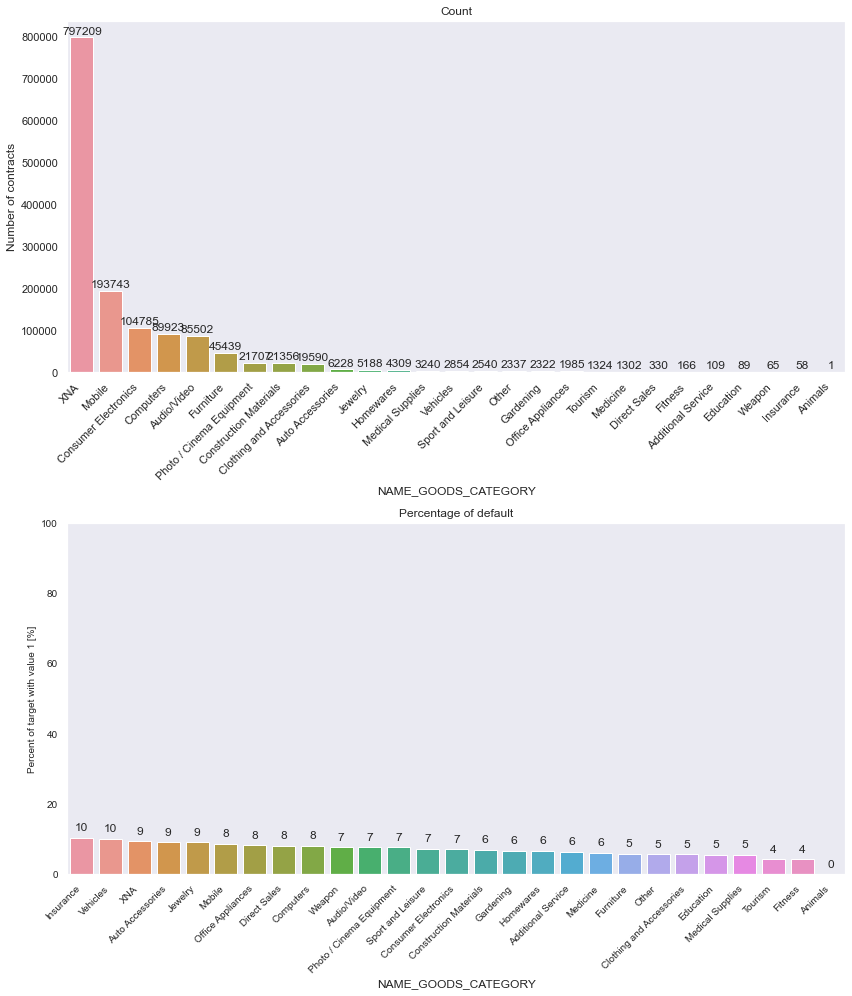

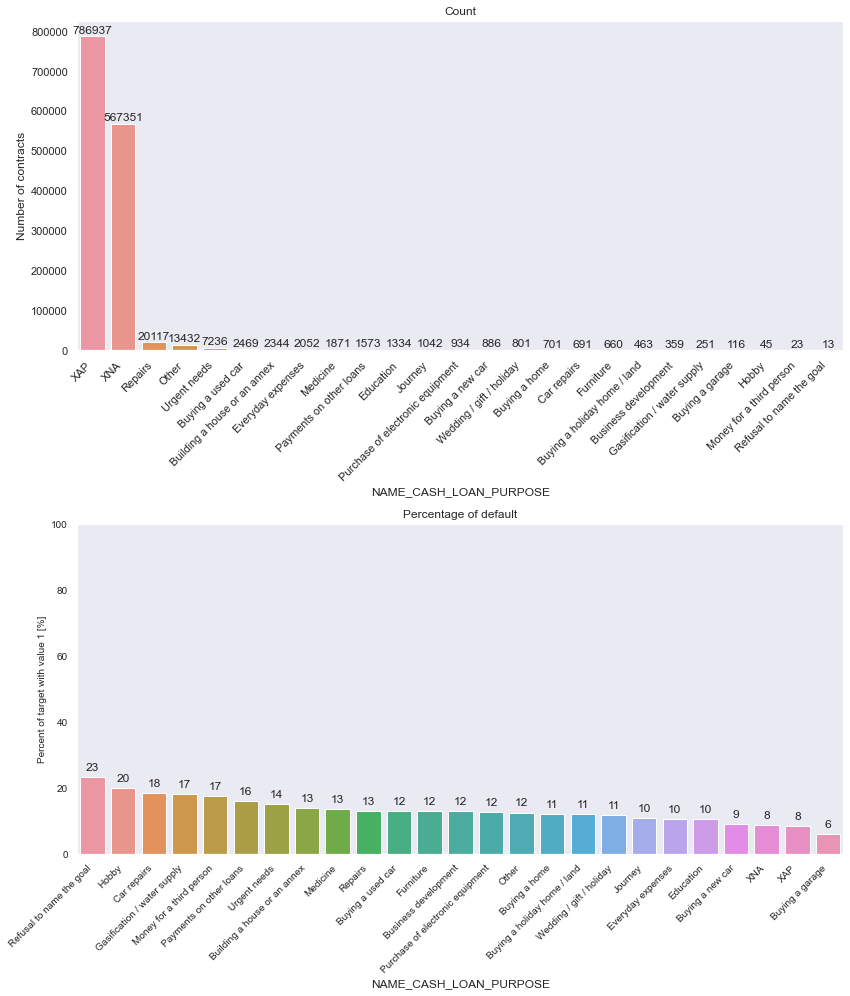

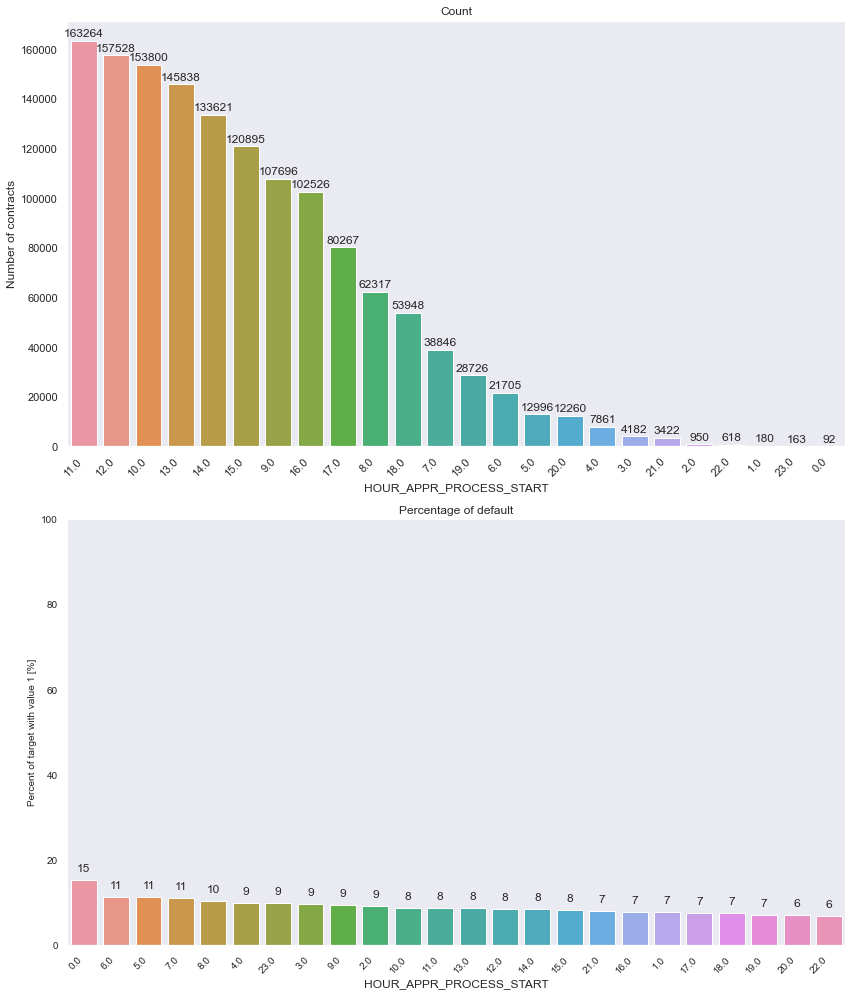

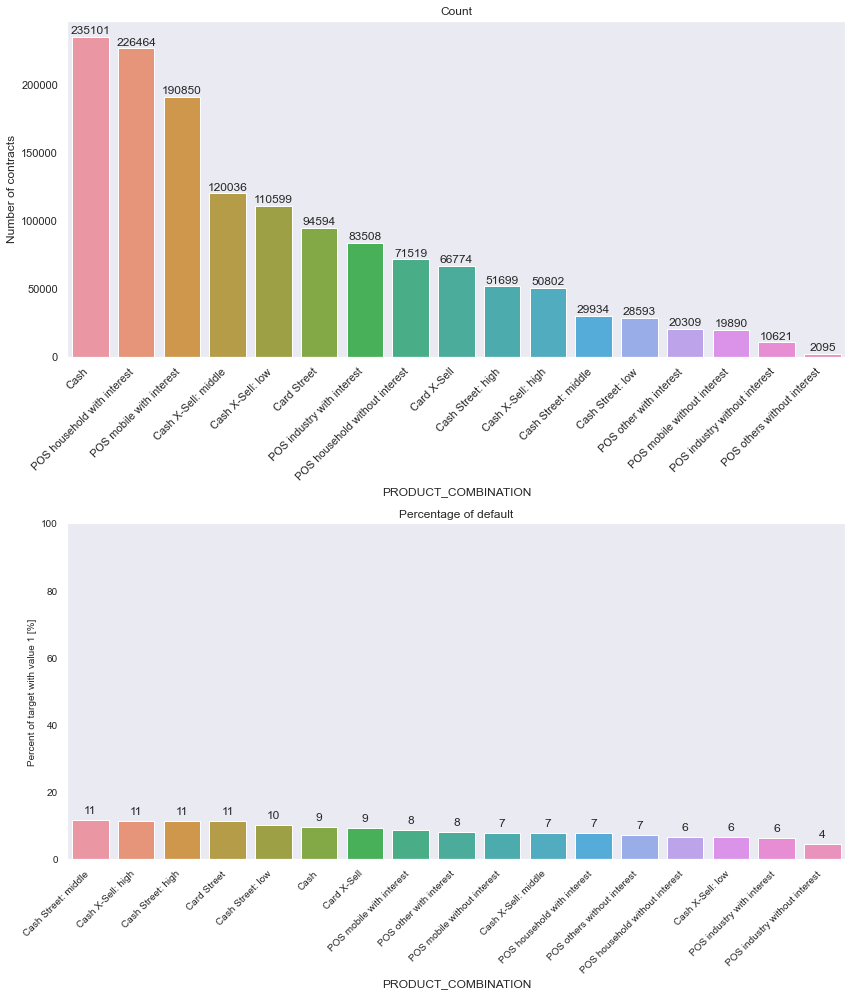

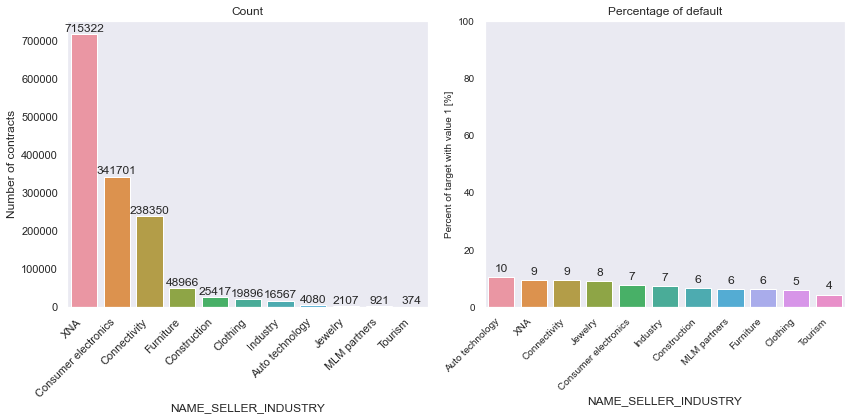

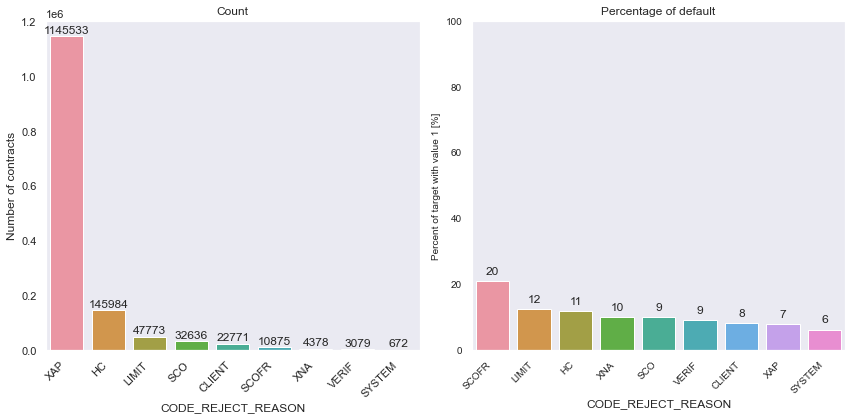

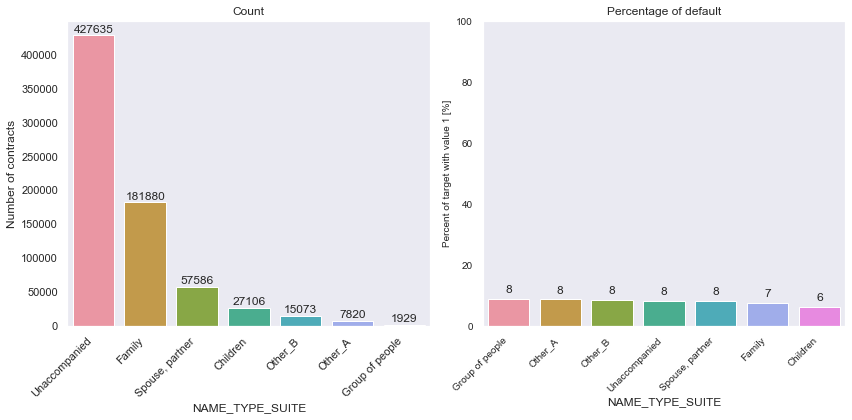

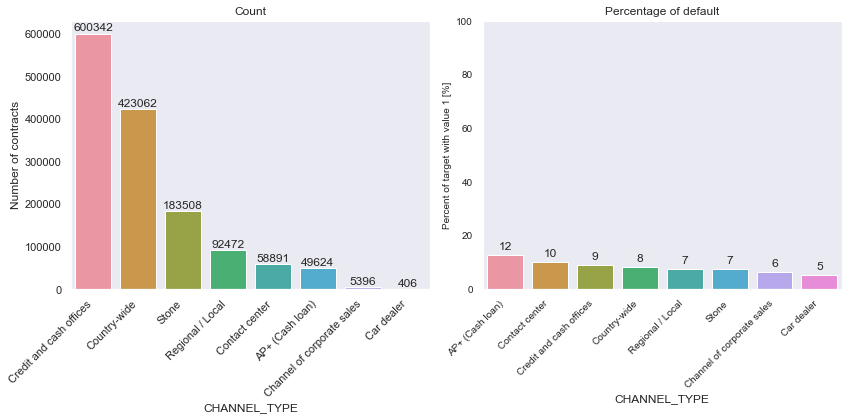

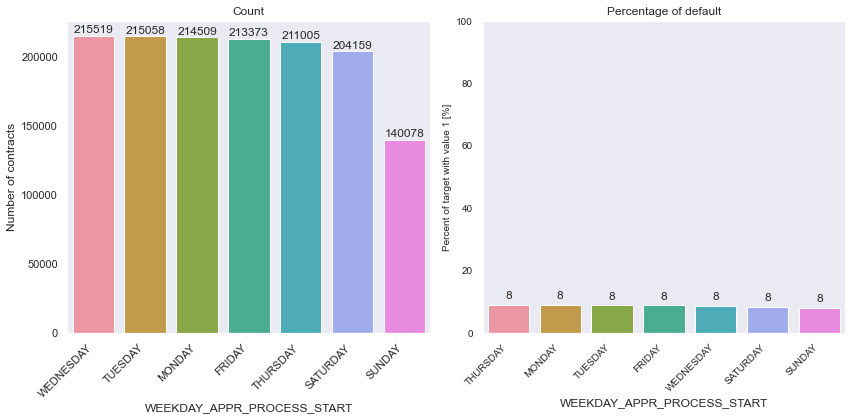

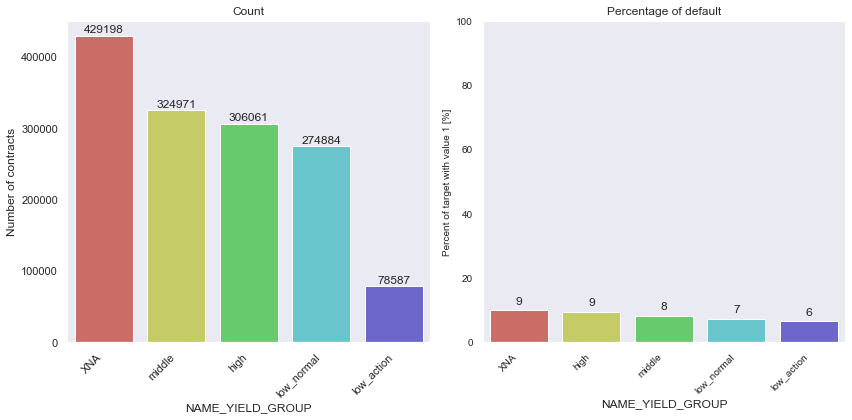

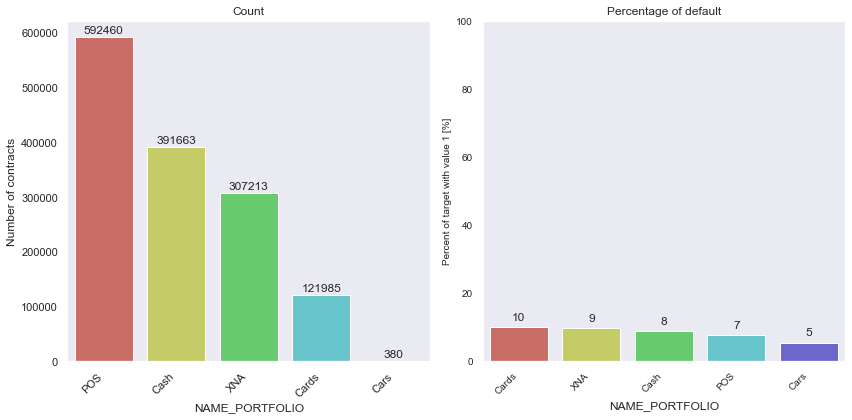

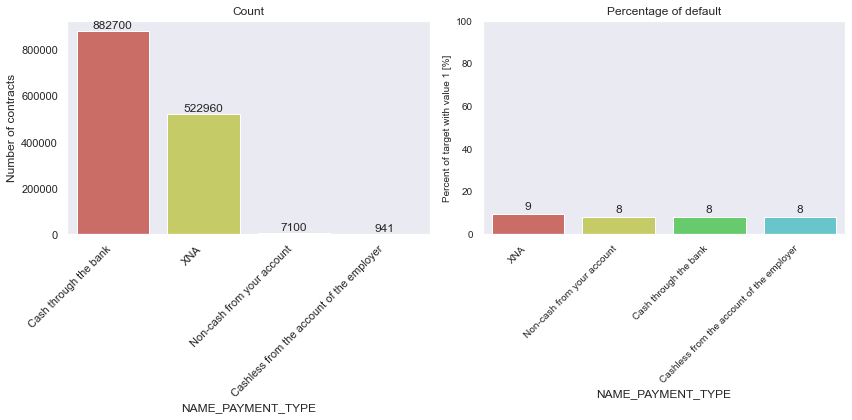

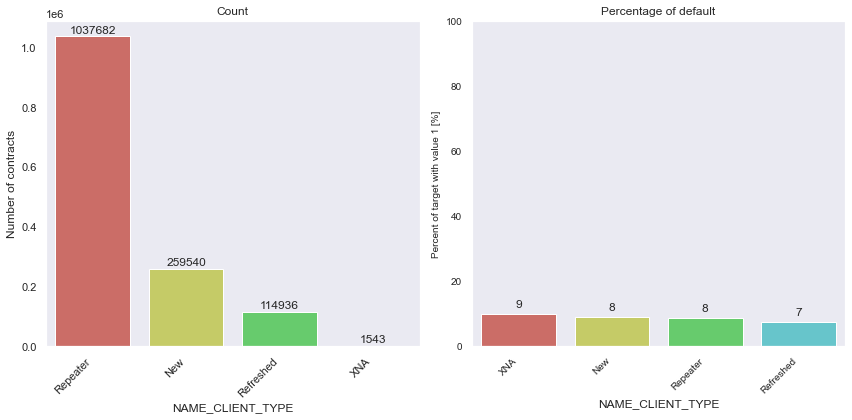

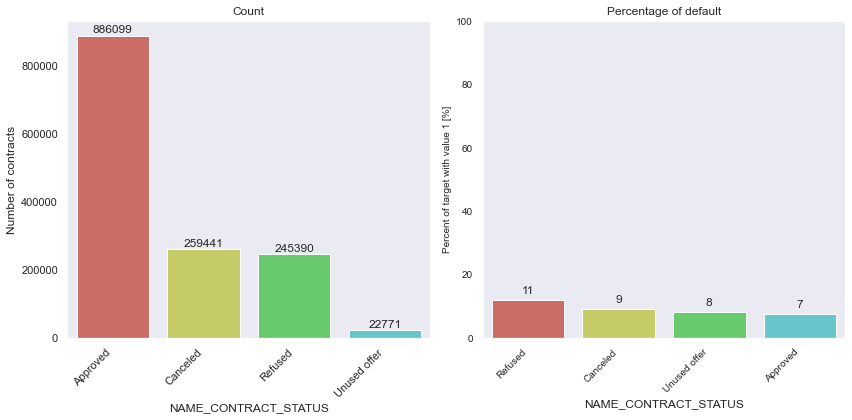

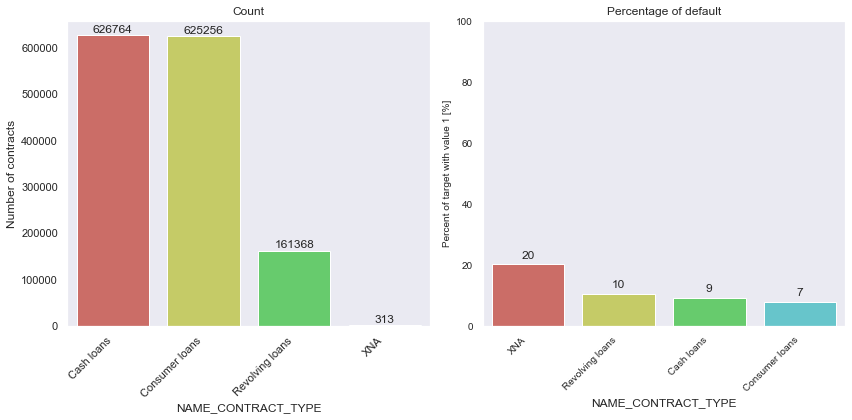

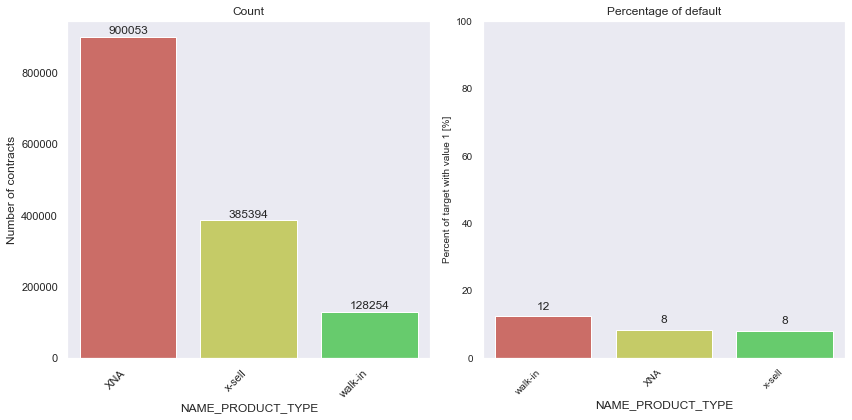

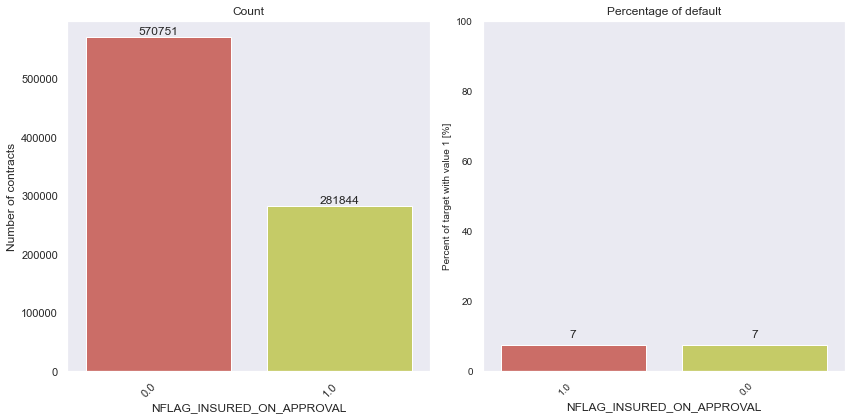

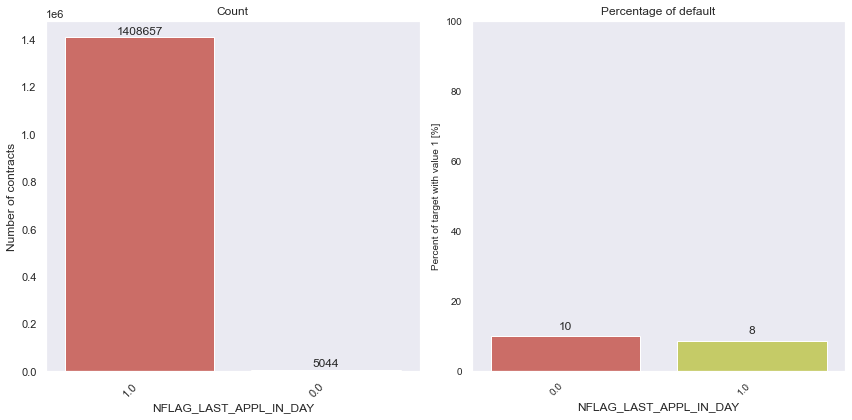

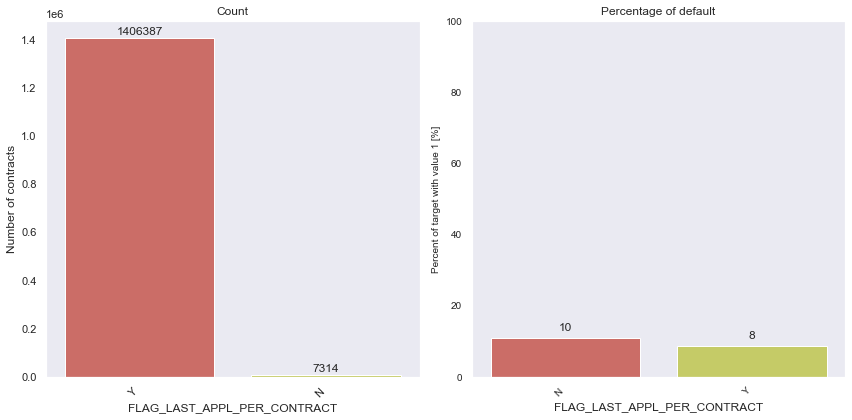

In [143]:
for i, j in enumerate(cat_cols):
    horizontal = False if i <= 3 else True
    plot_stats(j, df_prev_mrg, h=horizontal, label_rotation=True)

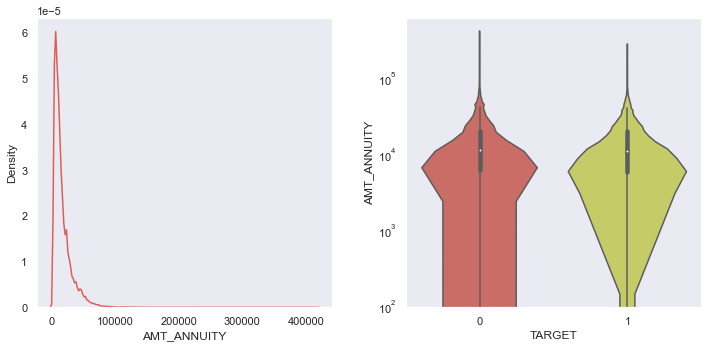

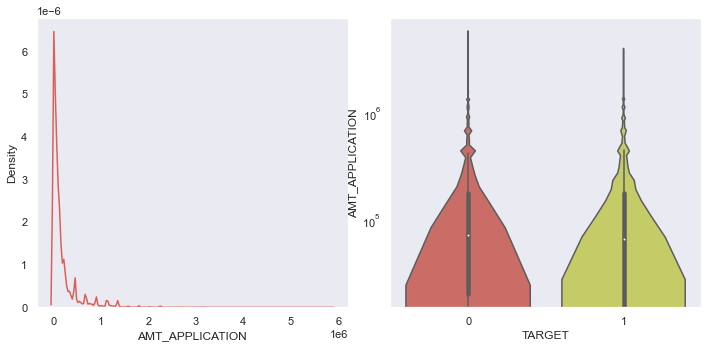

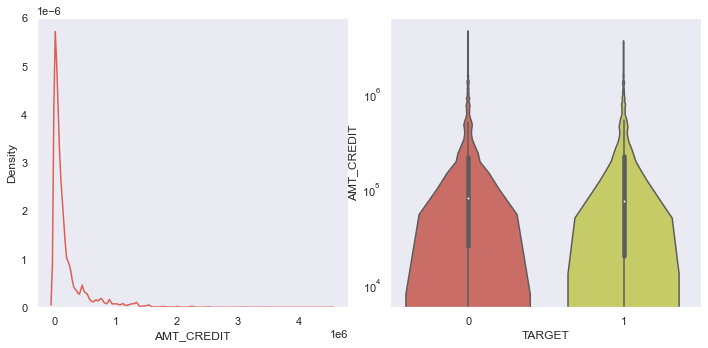

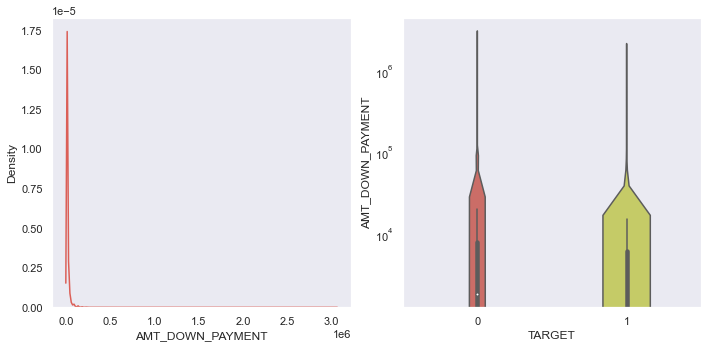

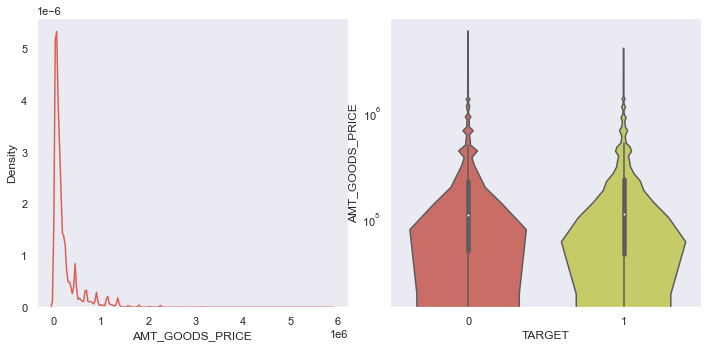

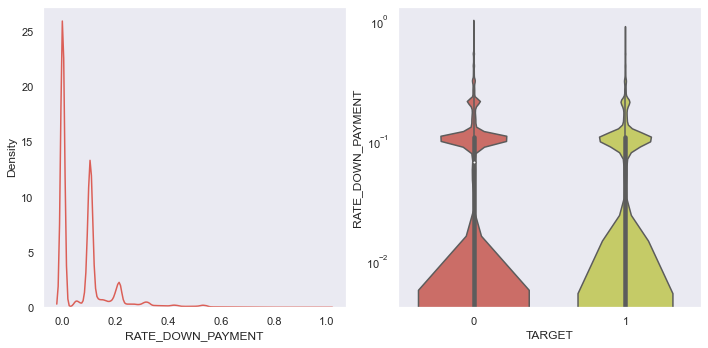

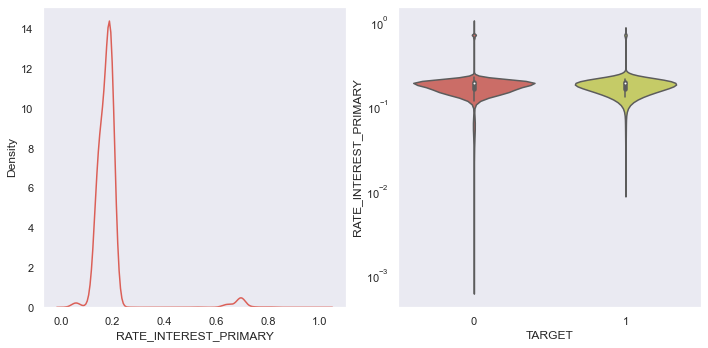

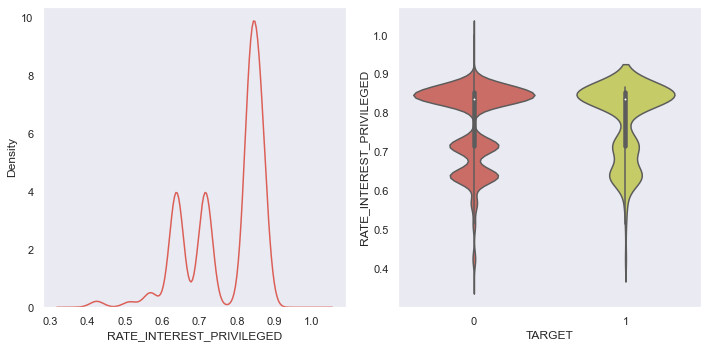

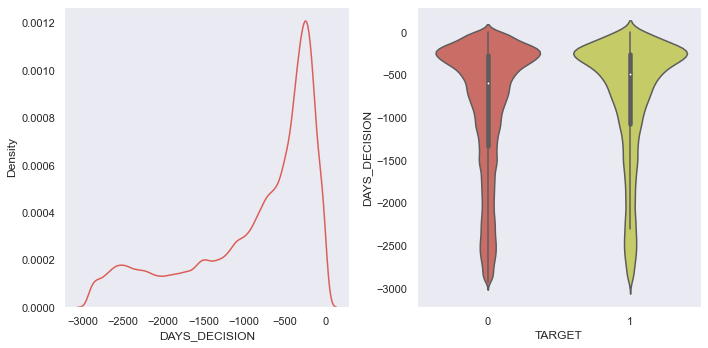

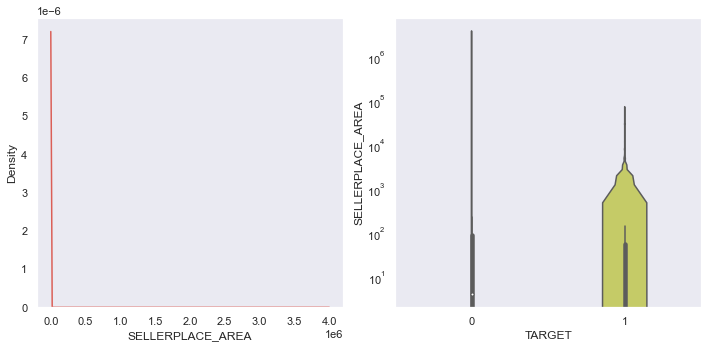

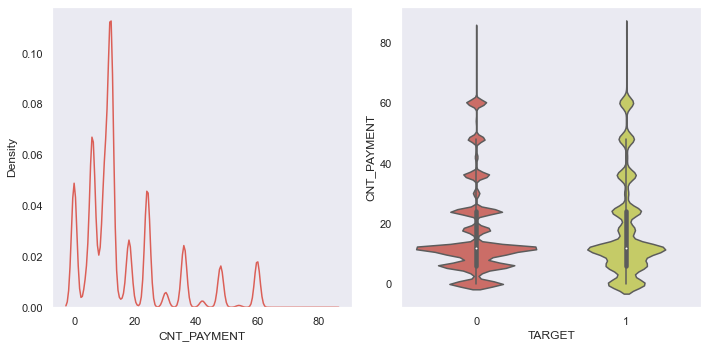

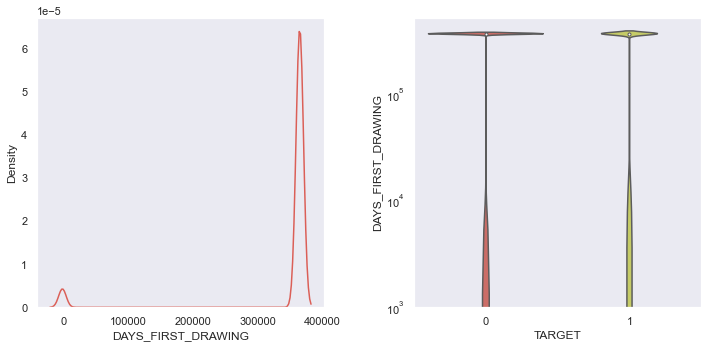

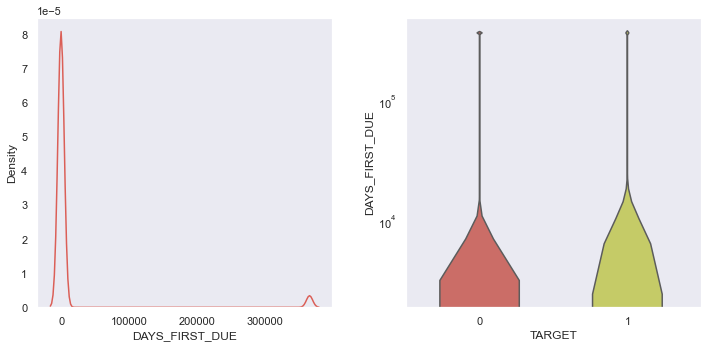

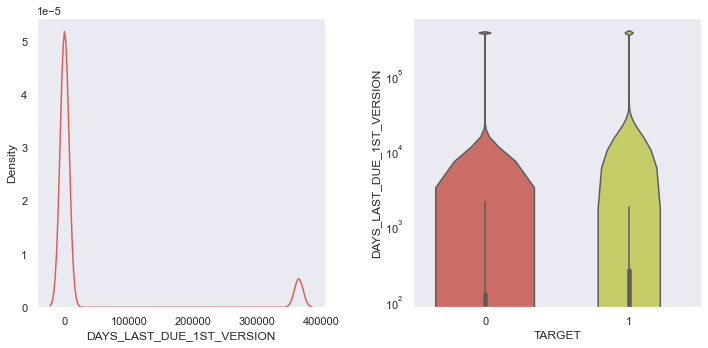

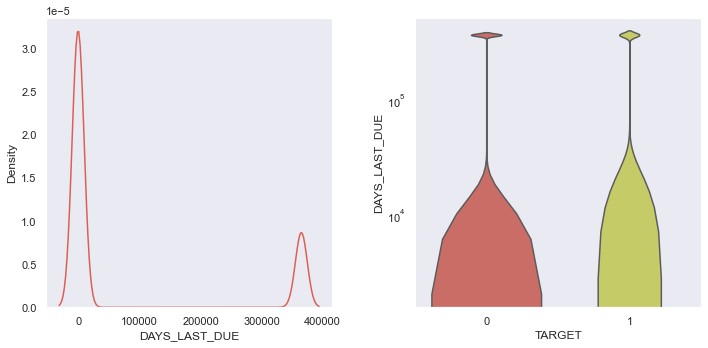

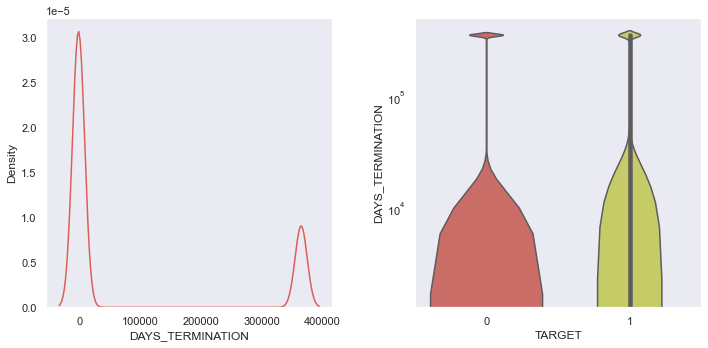

In [144]:
for i, j in enumerate(cont_cols):
    log = False if i in [7, 8, 10] else True
    plot_stats_cont(j, custom_df=df_prev_mrg, log=log)

## Bureau EDA

In [14]:
df_bur = pd.read_csv('bureau.csv')
df_bur_bal = pd.read_csv('bureau_balance.csv')

In [146]:
df_bur.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [147]:
df_bur_bal.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [15]:
unique = total_unique_values(df_bur)
unique


Column  Total Unique Values Datatype
1             SK_ID_BUREAU              1716428    int64
0               SK_ID_CURR               305811    int64
10          AMT_CREDIT_SUM               236709  float64
11     AMT_CREDIT_SUM_DEBT               226538  float64
8   AMT_CREDIT_MAX_OVERDUE                68252  float64
12    AMT_CREDIT_SUM_LIMIT                51727  float64
16             AMT_ANNUITY                40322  float64
6      DAYS_CREDIT_ENDDATE                14097  float64
15      DAYS_CREDIT_UPDATE                 2982    int64
4              DAYS_CREDIT                 2923    int64
7        DAYS_ENDDATE_FACT                 2918  float64
13  AMT_CREDIT_SUM_OVERDUE                 1616  float64
5       CREDIT_DAY_OVERDUE                  942    int64
14             CREDIT_TYPE                   15   object
9       CNT_CREDIT_PROLONG                   10    int64
3          CREDIT_CURRENCY                    4   object
2            CREDIT_ACTIVE                    4   object

In [16]:
cat_cols = unique.loc[unique['Total Unique Values'] <= 15, 'Column'].values
cont_cols = [i for i in df_bur.columns if i not in list(cat_cols) + ['SK_ID_BUREAU', 'SK_ID_CURR']]
df_bur_mrg = df_main_compact[['TARGET', 'SK_ID_CURR']].merge(df_bur, how='left', on='SK_ID_CURR')

In [17]:
stats(df_bur, cont_cols)

count        mean          std          min  \
DAYS_CREDIT             1716428.0   -1142.108      795.165    -2922.000   
CREDIT_DAY_OVERDUE      1716428.0       0.818       36.544        0.000   
DAYS_CREDIT_ENDDATE     1610875.0     510.517     4994.220   -42060.000   
DAYS_ENDDATE_FACT       1082775.0   -1017.437      714.011   -42023.000   
AMT_CREDIT_MAX_OVERDUE   591940.0    3825.418   206031.606        0.000   
AMT_CREDIT_SUM          1716415.0  354994.592  1149811.344        0.000   
AMT_CREDIT_SUM_DEBT     1458759.0  137085.120   677401.131 -4705600.320   
AMT_CREDIT_SUM_LIMIT    1124648.0    6229.515    45032.031  -586406.115   
AMT_CREDIT_SUM_OVERDUE  1716428.0      37.913     5937.650        0.000   
DAYS_CREDIT_UPDATE      1716428.0    -593.748      720.747   -41947.000   
AMT_ANNUITY              489637.0   15712.758   325826.949        0.000   

                            25%       50%       75%           max  
DAYS_CREDIT             -1666.0    -987.0    -474.0  0.000000e+00  
CREDIT_DAY_OVERDUE          0.0       0.0       0.0  2.792000e+03  
DAYS_CREDIT_ENDDATE     -1138.0    -330.0     474.0  3.119900e+04  
DAYS_ENDDATE_FACT       -1489.0    -897.0    -425.0  0.000000e+00  
AMT_CREDIT_MAX_OVERDUE      0.0       0.0       0.0  1.159872e+08  
AMT_CREDIT_SUM          51300.0  125518.5  315000.0  5.850000e+08  
AMT_CREDIT_SUM_DEBT         0.0       0.0   40153.5  1.701000e+08  
AMT_CREDIT_SUM_LIMIT        0.0       0.0       0.0  4.705600e+06  
AMT_CREDIT_SUM_OVERDUE      0.0       0.0       0.0  3.756681e+06  
DAYS_CREDIT_UPDATE       -908.0    -395.0     -33.0  3.720000e+02  
AMT_ANNUITY                 0.0       0.0   13500.0  1.184534e+08

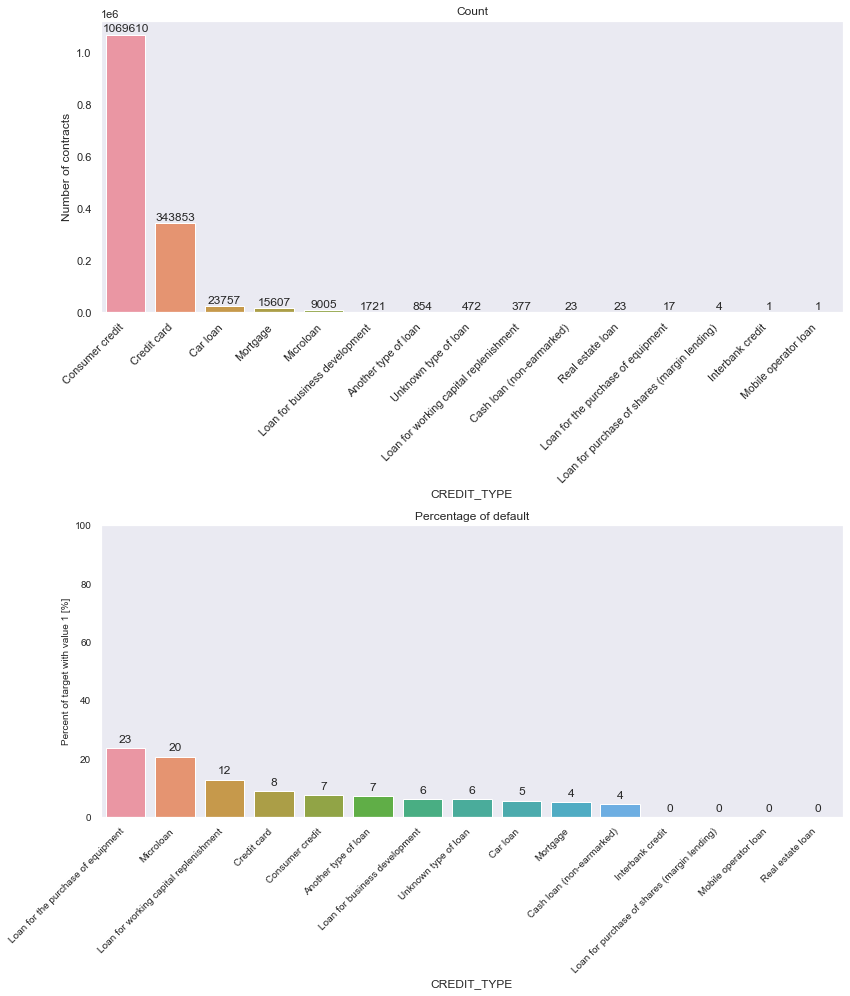

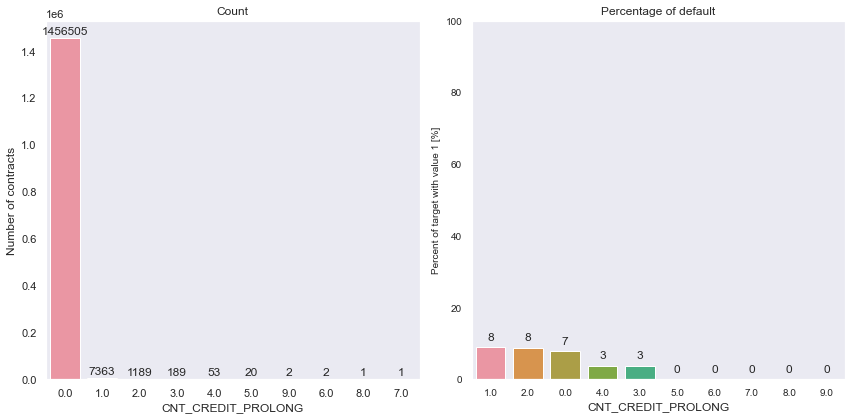

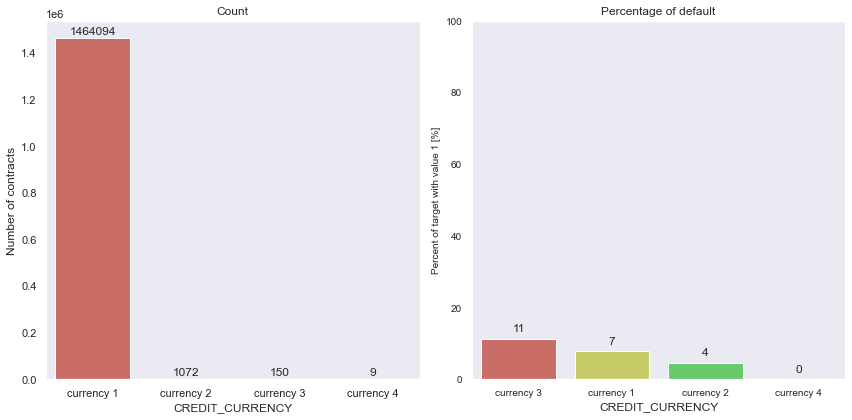

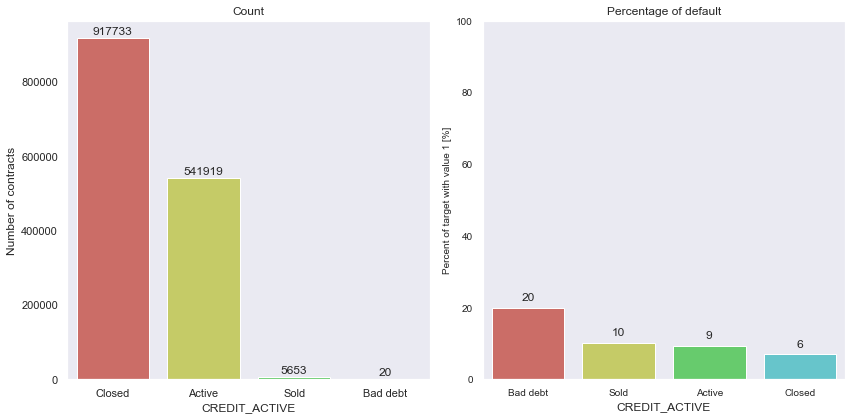

In [151]:
for i in cat_cols:
    plot_stats(i, df_bur_mrg, h=False if i=='CREDIT_TYPE' else True, label_rotation=True if i=='CREDIT_TYPE' else False)

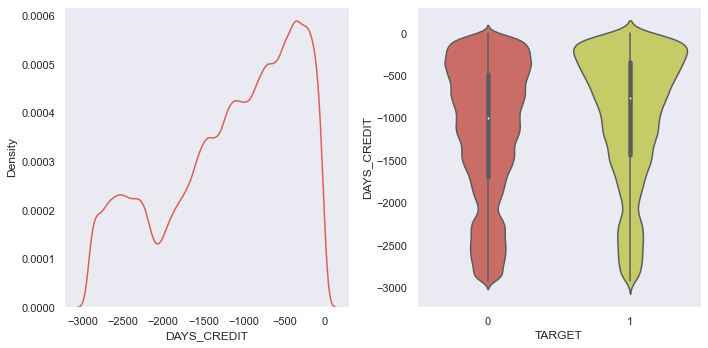

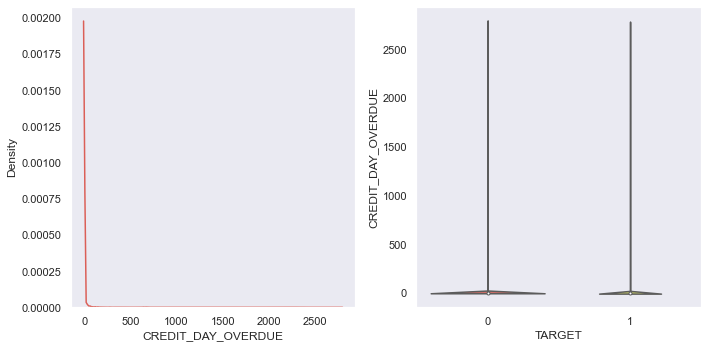

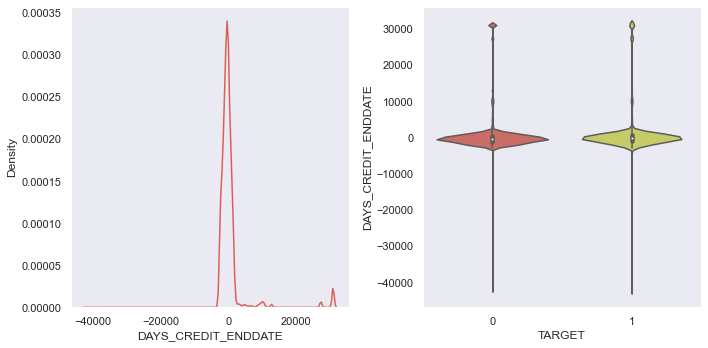

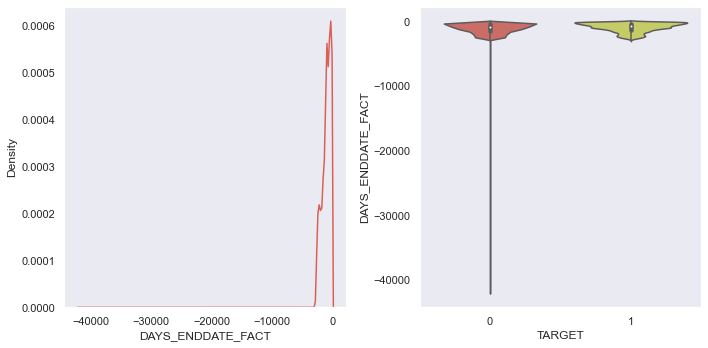

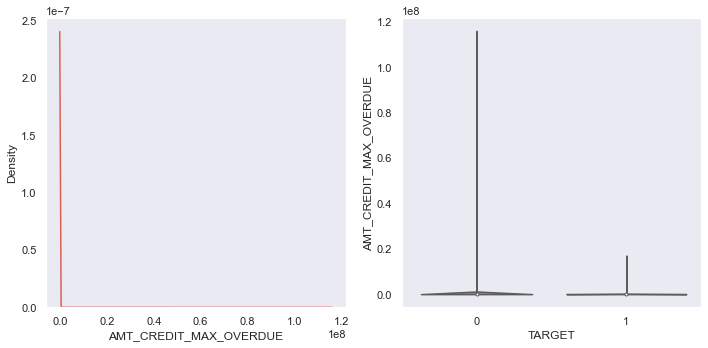

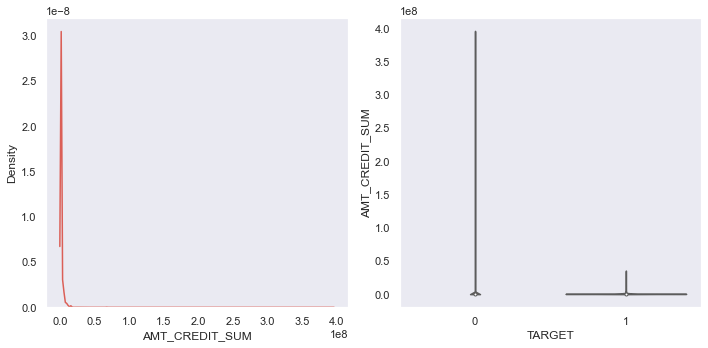

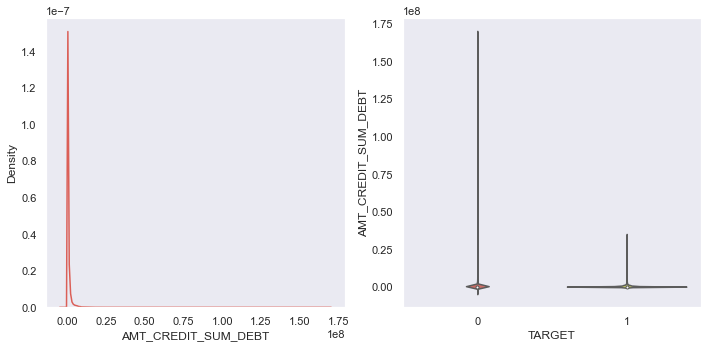

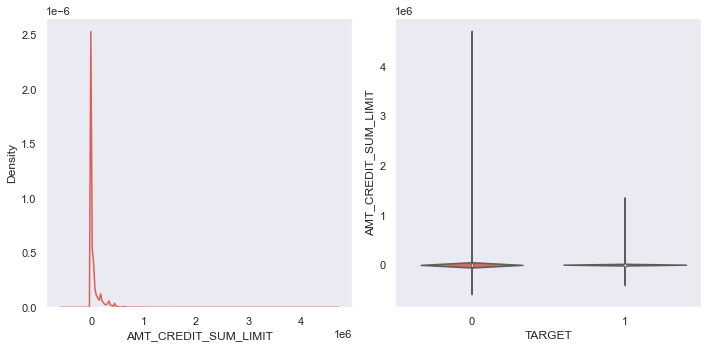

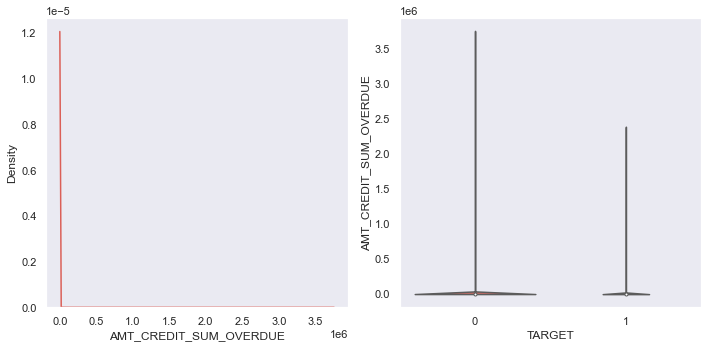

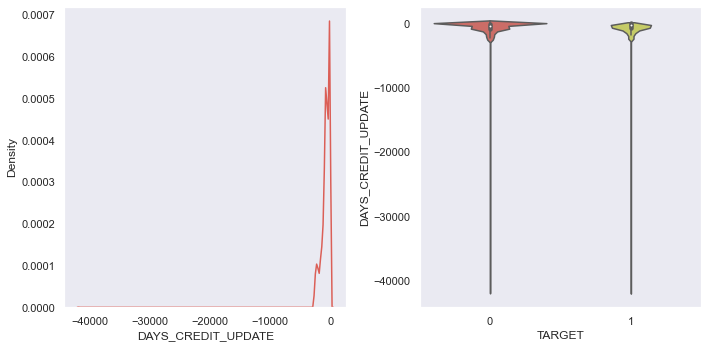

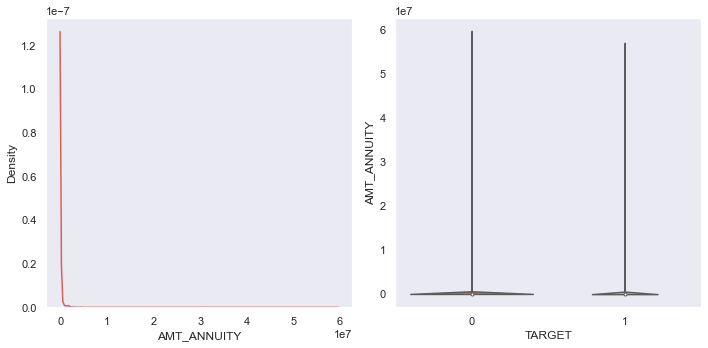

In [152]:
for i in cont_cols:
    plot_stats_cont(i, custom_df=df_bur_mrg)

In [132]:
df_cc_bal = pd.read_csv('credit_Card_balance.csv')
df_pos_cash = pd.read_csv('POS_CASH_balance.csv')
df_inst = pd.read_csv('installments_payments.csv')

In [135]:
df_cc_bal.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [153]:
cols = [i for i in df_cc_bal.columns if i not in ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_STATUS']]
stats(df_cc_bal, cols)

count        mean         std         min  \
MONTHS_BALANCE              3840312.0     -34.522      26.668     -96.000   
AMT_BALANCE                 3840312.0   58300.155  106307.031 -420250.185   
AMT_CREDIT_LIMIT_ACTUAL     3840312.0  153807.957  165145.700       0.000   
AMT_DRAWINGS_ATM_CURRENT    3090496.0    5961.325   28225.689   -6827.310   
AMT_DRAWINGS_CURRENT        3840312.0    7433.388   33846.077   -6211.620   
AMT_DRAWINGS_OTHER_CURRENT  3090496.0     288.170    8201.989       0.000   
AMT_DRAWINGS_POS_CURRENT    3090496.0    2968.805   20796.887       0.000   
AMT_INST_MIN_REGULARITY     3535076.0    3540.204    5600.154       0.000   
AMT_PAYMENT_CURRENT         3072324.0   10280.538   36078.085       0.000   
AMT_PAYMENT_TOTAL_CURRENT   3840312.0    7588.857   32005.988       0.000   
AMT_RECEIVABLE_PRINCIPAL    3840312.0   55965.877  102533.617 -423305.820   
AMT_RECIVABLE               3840312.0   58088.811  105965.370 -420250.185   
AMT_TOTAL_RECEIVABLE        3840312.0   58098.285  105971.801 -420250.185   
CNT_DRAWINGS_ATM_CURRENT    3090496.0       0.309       1.100       0.000   
CNT_DRAWINGS_CURRENT        3840312.0       0.703       3.190       0.000   
CNT_DRAWINGS_OTHER_CURRENT  3090496.0       0.005       0.083       0.000   
CNT_DRAWINGS_POS_CURRENT    3090496.0       0.559       3.241       0.000   
CNT_INSTALMENT_MATURE_CUM   3535076.0      20.825      20.051       0.000   
SK_DPD                      3840312.0       9.284      97.516       0.000   
SK_DPD_DEF                  3840312.0       0.332      21.479       0.000   

                                 25%       50%         75%          max  
MONTHS_BALANCE                -55.00     -28.0     -11.000       -1.000  
AMT_BALANCE                     0.00       0.0   89046.686  1505902.185  
AMT_CREDIT_LIMIT_ACTUAL     45000.00  112500.0  180000.000  1350000.000  
AMT_DRAWINGS_ATM_CURRENT        0.00       0.0       0.000  2115000.000  
AMT_DRAWINGS_CURRENT            0.00       0.0       0.000  2287098.315  
AMT_DRAWINGS_OTHER_CURRENT      0.00       0.0       0.000  1529847.000  
AMT_DRAWINGS_POS_CURRENT        0.00       0.0       0.000  2239274.160  
AMT_INST_MIN_REGULARITY         0.00       0.0    6633.911   202882.005  
AMT_PAYMENT_CURRENT           152.37    2702.7    9000.000  4289207.445  
AMT_PAYMENT_TOTAL_CURRENT       0.00       0.0    6750.000  4278315.690  
AMT_RECEIVABLE_PRINCIPAL        0.00       0.0   85359.240  1472316.795  
AMT_RECIVABLE                   0.00       0.0   88899.491  1493338.185  
AMT_TOTAL_RECEIVABLE            0.00       0.0   88914.510  1493338.185  
CNT_DRAWINGS_ATM_CURRENT        0.00       0.0       0.000       51.000  
CNT_DRAWINGS_CURRENT            0.00       0.0       0.000      165.000  
CNT_DRAWINGS_OTHER_CURRENT      0.00       0.0       0.000       12.000  
CNT_DRAWINGS_POS_CURRENT        0.00       0.0       0.000      165.000  
CNT_INSTALMENT_MATURE_CUM       4.00      15.0      32.000      120.000  
SK_DPD                          0.00       0.0       0.000     3260.000  
SK_DPD_DEF                      0.00       0.0       0.000     3260.000

In [138]:
df_pos_cash.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [154]:
cols = [i for i in df_pos_cash.columns if i not in ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_STATUS']]
stats(df_pos_cash, cols)

count    mean      std   min   25%   50%   75%  \
MONTHS_BALANCE         10001358.0 -35.013   26.067 -96.0 -54.0 -28.0 -13.0   
CNT_INSTALMENT          9975287.0  17.090   11.995   1.0  10.0  12.0  24.0   
CNT_INSTALMENT_FUTURE   9975271.0  10.484   11.109   0.0   3.0   7.0  14.0   
SK_DPD                 10001358.0  11.607  132.714   0.0   0.0   0.0   0.0   
SK_DPD_DEF             10001358.0   0.654   32.762   0.0   0.0   0.0   0.0   

                          max  
MONTHS_BALANCE           -1.0  
CNT_INSTALMENT           92.0  
CNT_INSTALMENT_FUTURE    85.0  
SK_DPD                 4231.0  
SK_DPD_DEF             3595.0

In [155]:
cols = [i for i in df_inst.columns if i not in ['SK_ID_PREV', 'SK_ID_CURR']]
stats(df_inst, cols)

count       mean        std     min       25%  \
NUM_INSTALMENT_VERSION  13605401.0      0.857      1.035     0.0     0.000   
NUM_INSTALMENT_NUMBER   13605401.0     18.871     26.664     1.0     4.000   
DAYS_INSTALMENT         13605401.0  -1042.270    800.946 -2922.0 -1654.000   
DAYS_ENTRY_PAYMENT      13602496.0  -1051.114    800.586 -4921.0 -1662.000   
AMT_INSTALMENT          13605401.0  17050.907  50570.254     0.0  4226.085   
AMT_PAYMENT             13602496.0  17238.223  54735.784     0.0  3398.265   

                             50%        75%          max  
NUM_INSTALMENT_VERSION     1.000      1.000      178.000  
NUM_INSTALMENT_NUMBER      8.000     19.000      277.000  
DAYS_INSTALMENT         -818.000   -361.000       -1.000  
DAYS_ENTRY_PAYMENT      -827.000   -370.000       -1.000  
AMT_INSTALMENT          8884.080  16710.210  3771487.845  
AMT_PAYMENT             8125.515  16108.425  3771487.845

# Preprocessing and Feature engineering


The choices I make and what I'll do in this section:

- I leave the missing values as is. A lot of the columns with missing values are missing half or more values, which makes imputation infeasible. We can't drop them because one of them might be an important feature. In turn, my choices of models are limited to tree models (and some other models) that can handle missing values.

- A lot of the numerical features have outliers, but I'll leave most of them. Some features about days have weird values and I removed the rows with these values. I also removed 4 people with gender 'XNA'.

- Each applicant have multiple records in datasets other than the current application dataset. That means for categorical variables, I can only do one-hot encoding for these datasets whereas for the current application dataset, I will choose label encoding. For numerical variables on these datasets, I will aggregate min, max, sum, mean, and variance for each of them. Yes, the number of features will explode but it won't be too big for me to process and I can discard useless features later. You can read the comments in the code to know what I'm trying to do.

- I'll create several features based on ratios and differences of the original features.

- No scaling whatsoever since I won't be using a linear model.

- I add 'create_half_train' parameter so that I can test the function on half of the dataset first.

- After preprocessing every dataset, I will reduce the memory usage by downcasting each column's datatype.

In [18]:
import gc
import warnings
warnings.simplefilter("ignore")
from tqdm import tqdm

def create_half_train():
    app_train = pd.read_csv('application_train.csv')
    app_train_pos = app_train.loc[app_train['TARGET'] == 1]
    app_train_neg = app_train.loc[app_train['TARGET'] == 0]

    train_pos = app_train_pos.iloc[:int(round(0.5*app_train_pos.shape[0], 0)), :]
    train_neg = app_train_neg.iloc[:int(round(0.5*app_train_neg.shape[0], 0)), :]
    train_ = train_pos.append(train_neg)
    return train_

def one_hot_encode(df, nan_cat = True):
    orig_col = df.columns.tolist()
    df_ohe = pd.get_dummies(df, dummy_na=nan_cat)
    return df_ohe, [i for i in df_ohe.columns if i not in orig_col]

def label_encode(df):
    cat_cols = [i for i in df.columns if df[i].dtypes == 'object']
    for i in cat_cols:
        df[i], indexer = pd.factorize(df[i])
        df[i].replace(-1, np.nan, inplace=True)
    return df, cat_cols

# from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def application_pipeline(half_app_train=False):
    train = pd.read_csv('application_train.csv')
    
    if half_app_train:
        train=create_half_train()
    
    test = pd.read_csv('application_test.csv')
    
    df = train.append(test)
    
    del train, test; gc.collect()
    
    
    # data cleaning
    
    df = df[df['AMT_INCOME_TOTAL'] < np.percentile(df['AMT_INCOME_TOTAL'], 99.9)]
    df = df[df['CODE_GENDER'] != 'XNA']
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # creating additional features
    
    df['ANNUITY/CREDIT'] =  df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['CREDIT/GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['ANNUITY/INCOME'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT/INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME/DAYS_EMPLOYED'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME/DAYS_BIRTH'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    df['EXT_SOURCE_PRODUCT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_1']
    df['EXT_SOURCE_SUM'] = df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']
    df['EXT_SOURCE_MEAN'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']) / 3

    df, app_cat_col = label_encode(df)
    
    
    # ADD AGGREGATE FEATURES LATER
    
    return df

In [19]:

def bureau_pipeline():
    bur = pd.read_csv('bureau.csv')
    bur_bal = pd.read_csv('bureau_balance.csv')
    
    # one-hot encoding
    bur, bur_cat = one_hot_encode(bur)
    bur_bal, bur_bal_cat = one_hot_encode(bur_bal)
    
    
    # creating additional features for bureau
    
    bur['CREDIT_DURATION'] = -bur['DAYS_CREDIT'] + bur['DAYS_CREDIT_ENDDATE']
    bur['ENDDATE_DIFF'] = bur['DAYS_CREDIT_ENDDATE'] - bur['DAYS_ENDDATE_FACT']
    bur['CREDIT/DEBT'] = bur['AMT_CREDIT_SUM'] / bur['AMT_CREDIT_SUM_DEBT']
    bur['DEBT_CREDIT_DIFF'] = bur['AMT_CREDIT_SUM'] - bur['AMT_CREDIT_SUM_DEBT']
    bur['CREDIT/ANNUITY'] = bur['AMT_CREDIT_SUM'] / bur['AMT_ANNUITY']
    
    # aggregating bureau balance
    
    bb_cat_agg = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']}
    for i in bur_bal_cat:
        bb_cat_agg[i] = ['mean']

    bur_bal = bur_bal.groupby('SK_ID_BUREAU').agg({**bb_cat_agg}).reset_index()
    bur_bal.columns = [f'BB_{i[0]}_{i[1]}' if 'BUREAU' not in i[0] else i[0] for i in bur_bal.columns]
    
    # merging bureau and bureau balance
    bur = bur.merge(bur_bal, on='SK_ID_BUREAU', how='left')
    
    del bur_bal; gc.collect()
    
    
    # aggregating categorical features
    bur_cat_agg = {}
    for i in bur_bal_cat:
        col = 'BB_' + i + '_' + 'mean'
        bur_cat_agg[col] = ['mean']
    for i in bur_cat:
        bur_cat_agg[i] = ['mean']
    
    # aggregating numerical features
    bur_num_agg = {}
    
    bur_new_feat = ['CREDIT_DURATION', 'ENDDATE_DIFF', 'CREDIT/DEBT', 'DEBT_CREDIT_DIFF', 'CREDIT/ANNUITY']
    bur_amt = [i for i in bur.columns if 'AMT' in i]
    bur_days = [i for i  in bur.columns if 'DAYS' in i and 'FACT' not in i]
    bur_num = bur_new_feat + bur_amt + bur_days + ['SK_ID_BUREAU']
    
    # aggregating min, max, mean, sum, var of num.features in bureau
    for i in bur_num:
        bur_num_agg[i] = ['min', 'max', 'mean', 'sum', 'var'] if i != 'SK_ID_BUREAU' else ['size']
    
    bur = bur.groupby('SK_ID_CURR').agg({**bur_cat_agg, **bur_num_agg}).reset_index()
    bur.columns = [f'BUR_{i[0]}_{i[1]}' if 'SK_ID_CURR' not in i[0] else i[0] for i in bur.columns]

    
    return bur

In [20]:
def previous_app_pipeline():
    prev = pd.read_csv('previous_application.csv')
    
    prev, prev_cat = one_hot_encode(prev)
    
    
    # data cleaning
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # adding additional features
    
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION/CREDIT'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT/ANNUITY'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT/CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    prev['AMT_PAYMENT'] = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (prev['AMT_PAYMENT']/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
    
    # aggregating categorical features
    prev_cat_agg = {}
    for i in prev_cat:
        prev_cat_agg[i] = ['mean']
        
    # aggregating numerical features
    prev_num_agg = {}
    prev_new_feat = ['APPLICATION_CREDIT_DIFF', 'APPLICATION/CREDIT', 'CREDIT/ANNUITY', 'DOWN_PAYMENT/CREDIT', 
                     'SIMPLE_INTERESTS', 'AMT_PAYMENT']
    prev_num = [
     'SK_ID_PREV',
     'AMT_ANNUITY',
     'AMT_APPLICATION',
     'AMT_CREDIT',
     'AMT_DOWN_PAYMENT',
     'AMT_GOODS_PRICE',
     'HOUR_APPR_PROCESS_START',
     'RATE_DOWN_PAYMENT',
     'RATE_INTEREST_PRIMARY',
     'RATE_INTEREST_PRIVILEGED',
     'DAYS_DECISION',
     'CNT_PAYMENT',
     'DAYS_FIRST_DRAWING',
     'DAYS_FIRST_DUE',
     'DAYS_LAST_DUE',
     'DAYS_TERMINATION'
    ]
    
    prev_num_all = prev_new_feat + prev_num
    
    for i in prev_num_all:
        prev_num_agg[i] = ['min', 'max', 'mean', 'sum', 'var'] if i != 'SK_ID_PREV' else ['size']
    
    prev = prev.groupby('SK_ID_CURR').agg({**prev_cat_agg, **prev_num_agg}).reset_index()
    prev.columns = [f'PREV_{i[0]}_{i[1]}' if 'SK_ID_CURR' not in i[0] else i[0] for i in prev.columns]
    
    
    return prev
    

In [21]:
def pos_cash_pipeline():
    pcb = pd.read_csv('POS_cash_balance.csv')
    pcb, pcb_cat = one_hot_encode(pcb)
    
    # aggregating categorical features
    pcb_cat_agg = {}
    for i in pcb_cat:
        pcb_cat_agg[i] = ['mean']
    
    # aggregating numerical features
    pcb_num_agg = {}
    pcb_num = ['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 
               'SK_DPD', 'SK_DPD_DEF']
    
    for i in pcb_num:
        agg = ['min', 'max', 'mean', 'sum', 'var']
        pcb_num_agg[i] = agg if i != 'MONTHS_BALANCE' else agg + ['size']
    
    pcb = pcb.groupby('SK_ID_CURR').agg({**pcb_cat_agg, **pcb_num_agg}).reset_index()
    pcb.columns = [f'PCB_{i[0]}_{i[1]}' if 'SK_ID_CURR' not in i[0] else i[0] for i in pcb.columns]
    
    return pcb

In [22]:
def credit_card_pipeline():
    ccb = pd.read_csv('credit_card_balance.csv')
    ccb, ccb_cat = one_hot_encode(ccb)
    
    # aggregating categorical features
    ccb_cat_agg = {}
    for i in ccb_cat:
        ccb_cat_agg[i] = ['mean']
    
    # aggregating numerical features
    ccb_num_agg = {}
    ccb_num = [
     'MONTHS_BALANCE',
     'AMT_BALANCE',
     'AMT_CREDIT_LIMIT_ACTUAL',
     'AMT_DRAWINGS_ATM_CURRENT',
     'AMT_DRAWINGS_CURRENT',
     'AMT_DRAWINGS_OTHER_CURRENT',
     'AMT_DRAWINGS_POS_CURRENT',
     'AMT_INST_MIN_REGULARITY',
     'AMT_PAYMENT_CURRENT',
     'AMT_PAYMENT_TOTAL_CURRENT',
     'AMT_RECEIVABLE_PRINCIPAL',
     'AMT_RECIVABLE',
     'AMT_TOTAL_RECEIVABLE',
     'CNT_DRAWINGS_ATM_CURRENT',
     'CNT_DRAWINGS_CURRENT',
     'CNT_DRAWINGS_OTHER_CURRENT',
     'CNT_DRAWINGS_POS_CURRENT',
     'CNT_INSTALMENT_MATURE_CUM',
     'SK_DPD',
     'SK_DPD_DEF']
    
    for i in ccb_num:
        agg = ['min', 'max', 'mean', 'sum', 'var']
        ccb_num_agg[i] = agg if i != 'MONTHS_BALANCE' else agg + ['size']
    
    ccb = ccb.groupby('SK_ID_CURR').agg({**ccb_cat_agg, **ccb_num_agg}).reset_index()
    ccb.columns = [f'CCB_{i[0]}_{i[1]}' if 'SK_ID_CURR' not in i[0] else i[0] for i in ccb.columns]
    
    
    return ccb

In [23]:
def installments_pipeline():
    inst = pd.read_csv('installments_payments.csv')
    
    # creating additional features for installments
    inst['PAYMENT/INSTALMENT'] = inst['AMT_PAYMENT'] / inst['AMT_INSTALMENT']
    inst['PAYMENT_DIFF'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
    inst['DPD'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
    inst['DBD'] = inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']
    inst['DPD'] = inst['DPD'].apply(lambda x: x if x > 0 else 0)
    inst['DBD'] = inst['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # aggregating numerical features (no categoricals here)
    inst_num_agg = {}
    inst_num = ['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_INSTALMENT',
                'DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT', 'PAYMENT/INSTALMENT',
                'PAYMENT_DIFF', 'DPD', 'DBD']
    for i in inst_num:
        agg = ['min', 'max', 'mean', 'sum', 'var']
        inst_num_agg[i] = agg if i != 'DAYS_INSTALMENT' else agg + ['size']
    inst = inst.groupby('SK_ID_CURR').agg({**inst_num_agg}).reset_index()
    inst.columns = [f'INST_{i[0]}_{i[1]}' if 'SK_ID_CURR' not in i[0] else i[0] for i in inst.columns]
    
    return inst

In [24]:
def main_pipeline(reduce_mem=True, half_train=False):
    df = application_pipeline(half_train)
    bur = bureau_pipeline()
    df = df.merge(bur, on='SK_ID_CURR', how='left')
    del bur; gc.collect()
    prev = previous_app_pipeline()
    df = df.merge(prev, on='SK_ID_CURR', how='left')
    del prev; gc.collect()
    pcb = pos_cash_pipeline()
    df = df.merge(pcb, on='SK_ID_CURR', how='left')
    del pcb; gc.collect()
    ccb = credit_card_pipeline()
    df = df.merge(ccb, on='SK_ID_CURR', how='left')
    del ccb; gc.collect()
    inst = installments_pipeline()
    df = df.merge(inst, on='SK_ID_CURR', how='left')
    del inst; gc.collect()
    
    if reduce_mem:
        df = reduce_memory(df)
        
    return df

In [25]:
%%time
df = main_pipeline()
df.head()

Memory usage of dataframe is 1897.05 MB
Memory usage after optimization is: 630.99 MB
Decreased by 66.7%
Wall time: 2min 58s


SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002     1.0                   0            0             0   
1      100003     0.0                   0            1             0   
2      100004     0.0                   1            0             1   
3      100006     0.0                   0            1             0   
4      100007     0.0                   0            0             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                0             0          202500.0    406597.5      24700.5   
1                1             0          270000.0   1293502.5      35698.5   
2                0             0           67500.0    135000.0       6750.0   
3                0             0          135000.0    312682.5      29686.5   
4                0             0          121500.0    513000.0      21865.5   

   ...  INST_DPD_min  INST_DPD_max  INST_DPD_mean  INST_DPD_sum  INST_DPD_var  \
0  ...           0.0           0.0        0.00000           0.0      0.000000   
1  ...           0.0           0.0        0.00000           0.0      0.000000   
2  ...           0.0           0.0        0.00000           0.0      0.000000   
3  ...           0.0           0.0        0.00000           0.0      0.000000   
4  ...           0.0          12.0        0.95459          63.0      5.305594   

   INST_DBD_min  INST_DBD_max  INST_DBD_mean  INST_DBD_sum  INST_DBD_var  
0          12.0          31.0      20.421875         388.0     24.257311  
1           1.0          14.0       7.160156         179.0     13.890000  
2           3.0          11.0       7.667969          23.0     17.333334  
3           1.0          77.0      19.375000         310.0    645.049988  
4           0.0          31.0       4.589844         303.0     49.660839  

[5 rows x 698 columns]

# Modelling

## Shortlisting Models

Here's what I'm gonna do:

1. Split the dataset into two parts: training (80%) and testing set (20%). We don't want to accidentally pick an overfitting model, so model validation is an imperative. This is about the minimum required and I think it's okay. I don't want to do a cross-validation because this is a relatively large dataset and it will take forever to fit the three models for all the folds.

2. Train the models. I choose XGBoost, LightGBM, and CatBoost because of their great performance and speed AND especially their ability to handle missing values.

3. Choose the best model, speed and time-wise, and optimize the hyperparameters.

4. Do cross-validation. I choose Stratified K-Fold with 5 folds due to the imbalanced nature of the data.

In [27]:
test = df[df['TARGET'].isna()]
train = df[df['TARGET'].notna()]
y = train['TARGET']
X = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)

In [28]:
# splitting train into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2, random_state=22)

### Fitting XGBoost

In [83]:
%%time

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'n_estimators': 5000,
    'n_jobs': -1,
    'learning_rate': 0.01,
    'random_state': 22,
    'tree_method': 'gpu_hist'
}

clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=100, verbose=100)

[0]	validation_0-auc:0.71050
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.73590
[200]	validation_0-auc:0.74563
[300]	validation_0-auc:0.75725
[400]	validation_0-auc:0.76607
[500]	validation_0-auc:0.77208
[600]	validation_0-auc:0.77590
[700]	validation_0-auc:0.77855
[800]	validation_0-auc:0.78060
[900]	validation_0-auc:0.78218
[1000]	validation_0-auc:0.78335
[1100]	validation_0-auc:0.78424
[1200]	validation_0-auc:0.78503
[1300]	validation_0-auc:0.78568
[1400]	validation_0-auc:0.78625
[1500]	validation_0-auc:0.78674
[1600]	validation_0-auc:0.78722
[1700]	validation_0-auc:0.78767
[1800]	validation_0-auc:0.78792
[1900]	validation_0-auc:0.78815
[2000]	validation_0-auc:0.78838
[2100]	validation_0-auc:0.78868
[2200]	validation_0-auc:0.78884
[2300]	validation_0-auc:0.78902
[2400]	validation_0-auc:0.78905
[2500]	validation_0-auc:0.78912
[2600]	validation_0-auc:0.78912
Stopping. Best iteration:
[2514]	validation_0-auc:0.78914

Wall time: 8min 1s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=5000, n_jobs=-1, num_parallel_tree=1,
              random_state=22, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

### Fitting LightGBM

In [67]:
%%time

# apparently LGBM won't accept certain characters in column names
for i in [X_train, X_test]:
    i.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)


clf_lgbm = lgbm.LGBMClassifier(n_jobs=-1, n_estimators=10000, boosting='goss', learning_rate=0.005, random_state=22)
# clf_lgbm = lgbm.LGBMClassifier(**PARAMS)

clf_lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=200, verbose=200)

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.742515	valid_0's binary_logloss: 0.256758
[400]	valid_0's auc: 0.760139	valid_0's binary_logloss: 0.248675
[600]	valid_0's auc: 0.769052	valid_0's binary_logloss: 0.244593
[800]	valid_0's auc: 0.774316	valid_0's binary_logloss: 0.242254
[1000]	valid_0's auc: 0.777665	valid_0's binary_logloss: 0.240774
[1200]	valid_0's auc: 0.780498	valid_0's binary_logloss: 0.239691
[1400]	valid_0's auc: 0.782613	valid_0's binary_logloss: 0.238908
[1600]	valid_0's auc: 0.783994	valid_0's binary_logloss: 0.238386
[1800]	valid_0's auc: 0.785073	valid_0's binary_logloss: 0.237978
[2000]	valid_0's auc: 0.785898	valid_0's binary_logloss: 0.23768
[2200]	valid_0's auc: 0.786709	valid_0's binary_logloss: 0.237395
[2400]	valid_0's auc: 0.787141	valid_0's binary_logloss: 0.237233
[2600]	valid_0's auc: 0.78759	valid_0's binary_logloss: 0.237075
[2800]	valid_0's auc: 0.787938	valid_0's binary_logloss: 0.23696
[3000]	valid_0's auc:

LGBMClassifier(boosting='goss', learning_rate=0.005, n_estimators=10000,
               random_state=22)

### Fitting CatBoost

In [29]:
# CatBoost seems to have trouble processing features with int16, int8, and float16
# This method upcasts the datatype to the lowest(?) datatype accepted by CatBoost, which is float32 and int32

def upcast_dtypes(df):
    col = []
    for i in df.columns:
        if df[i].dtypes == 'float16':
            df[i] = df[i].astype('float32')
        elif df[i].dtypes == 'int8' or df[i].dtypes == 'int16':
            df[i] = df[i].astype('int32')
    return df

In [30]:
X_train = upcast_dtypes(X_train)
X_test = upcast_dtypes(X_test)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [31]:
%%time


clf_catboost = catboost.CatBoostClassifier(iterations=35000, learning_rate=0.01, eval_metric='AUC', task_type='GPU', random_state=22)
clf_catboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=1000, verbose=1000)

0:	learn: 0.7022436	test: 0.6961910	best: 0.6961910 (0)	total: 72.1ms	remaining: 42m 3s
1000:	learn: 0.7908266	test: 0.7782352	best: 0.7782352 (1000)	total: 51.3s	remaining: 29m 3s
2000:	learn: 0.8036724	test: 0.7834390	best: 0.7834390 (2000)	total: 1m 37s	remaining: 26m 47s
3000:	learn: 0.8132542	test: 0.7860109	best: 0.7860109 (3000)	total: 2m 22s	remaining: 25m 23s
4000:	learn: 0.8215470	test: 0.7874779	best: 0.7874787 (3999)	total: 3m 7s	remaining: 24m 15s
5000:	learn: 0.8292512	test: 0.7884763	best: 0.7884772 (4999)	total: 3m 52s	remaining: 23m 15s
6000:	learn: 0.8364384	test: 0.7893465	best: 0.7893465 (6000)	total: 4m 37s	remaining: 22m 21s
7000:	learn: 0.8431361	test: 0.7898813	best: 0.7898821 (6995)	total: 5m 22s	remaining: 21m 29s
8000:	learn: 0.8495060	test: 0.7902349	best: 0.7902349 (8000)	total: 6m 7s	remaining: 20m 41s
9000:	learn: 0.8556110	test: 0.7906748	best: 0.7906752 (8999)	total: 6m 52s	remaining: 19m 52s
10000:	learn: 0.8615608	test: 0.7910304	best: 0.7910362 (9997

Summarizing, here are the AUC score and elapsed time for each model:
1. XGBoost: 0.78914, 7 min 48 s
2. LightGBM: 0.79014, 23 min 33 s
3. CatBoost: 0.79195, 12 min 25 s

CatBoost is the best performing model untuned and it is the second best model in terms of fitting time. However the margin is really small and I think it's within margin of error. Note that XGBoost and CatBoost were trained on GPU while LightGBM was trained on CPU. In results, the discrepancy between the time spent fitting is significantly faster, but not orders of magnitude faster.

This is interesting because on Kaggle, most people seem to prefer LightGBM. I think the reason is speed; between the 2 better models, LightGBM at the time was relatively faster compared to CatBoost, but now CatBoost can utilize GPU and reap the benefit of way better parallelization.

In [94]:
for i, j in {'XGBoost': clf_xgb , 'LightGBM': clf_lgbm, 'CatBoost': clf_catboost}.items():
    y_pred = j.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(i, '\n', cm, '\n')

XGBoost 
 [[56262   189]
 [ 4718   242]] 

LightGBM 
 [[56264   187]
 [ 4719   241]] 

CatBoost 
 [[56237   214]
 [ 4706   254]] 



In [131]:

# I created the df manually because I can't parse the CMs above since it was run the day before
# and I don't want to rerun it again

cm_df = pd.DataFrame({'Models': ['XGBoost', 'LightGBM', 'Catboost'], 
                      'True Positive': [242, 241, 254],
                      'False Negative': [4718, 4719, 4706],
                      'True Negative': [56262, 56264, 56237],
                      'False Positive': [189, 187, 214]})

cm_df['Precision (%)'] = cm_df['True Positive'] * 100 / (cm_df['True Positive'] + cm_df['False Positive'])
cm_df['Recall (%)'] = cm_df['True Positive'] * 100 / (cm_df['True Positive'] + cm_df['False Negative'])

cm_df

Models  True Positive  False Negative  True Negative  False Positive  \
0   XGBoost            242            4718          56262             189   
1  LightGBM            241            4719          56264             187   
2  Catboost            254            4706          56237             214   

   Precision (%)  Recall (%)  
0      56.148492    4.879032  
1      56.308411    4.858871  
2      54.273504    5.120968

This is an overview of class prediction by each model. You can see that that all three models make roughly similar prediction and similar mistakes; in other words, these models are not diverse. This means that we can't put the three of them into an ensemble to create a better predictor.

Talking about score (ROC-AUC), it appears that the models are really good at predicting negative class (non-risky people) and really bad at predicting positive class. ROC-AUC was the metric used to judge the competition (for this dataset) on Kaggle, even in spite of the imbalanced nature of the dataset. Optimizing for a higher score, the competitors found that NOT altering the parameters that are meant to be set for imbalanced dataset leads to higher ROC-AUC. Doing it this way, the models can be fit without any restriction to achieve the highest scores, even when heavily misclassifying the underrepresented positive class.

Here's what I'll do:
1. Train the CatBoost model with the 'class_weights' parameter specified (0.1, 1 for class 0, class 1)
2. Look at the precision-recall at various thresholds and determine a good threshold

In [131]:
%%time


clf_catboost = catboost.CatBoostClassifier(iterations=35000, learning_rate=0.01, eval_metric='Logloss', task_type='GPU', class_weights=[0.09, 1], random_state=22)
clf_catboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=1000, verbose=1000)

y_pred = clf_catboost.predict(X_test)

print(f"""
F1: {f1_score(y_test, y_pred)}
ROC: {roc_auc_score(y_test, y_pred)}
Precision: {precision_score(y_test, y_pred)}
Recall: {recall_score(y_test, y_pred)}""")

0:	learn: 0.6916461	test: 0.6916884	best: 0.6916884 (0)	total: 58.2ms	remaining: 33m 57s
1000:	learn: 0.5514463	test: 0.5663769	best: 0.5663729 (999)	total: 46.6s	remaining: 26m 23s
2000:	learn: 0.5294115	test: 0.5591808	best: 0.5591808 (2000)	total: 1m 30s	remaining: 24m 45s
3000:	learn: 0.5120978	test: 0.5568880	best: 0.5568677 (2992)	total: 2m 13s	remaining: 23m 43s
4000:	learn: 0.4968026	test: 0.5558301	best: 0.5558255 (3996)	total: 2m 56s	remaining: 22m 45s
5000:	learn: 0.4829974	test: 0.5556056	best: 0.5555569 (4393)	total: 3m 39s	remaining: 21m 56s
6000:	learn: 0.4698794	test: 0.5557912	best: 0.5555317 (5330)	total: 4m 22s	remaining: 21m 10s
bestTest = 0.5555316833
bestIteration = 5330
Shrink model to first 5331 iterations.

F1: 0.30739353585795537
ROC: 0.7168985048980532
Precision: 0.1994360112797744
Recall: 0.6701612903225806
Wall time: 4min 45s


The model is doing much better now at predicting the positive class, of course at the expense of misclassifying a lot of the negative class. But if you look at it, the precision is not that good to begin with (around 50%). Now the recall is at 66% (compared to 4-5% previously), with a precision around 20% (a decrease of 30%).

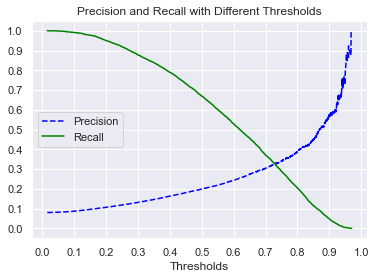

In [88]:
y_pred_proba = clf_catboost.predict_proba(X_test)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.title('Precision and Recall with Different Thresholds')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Thresholds')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

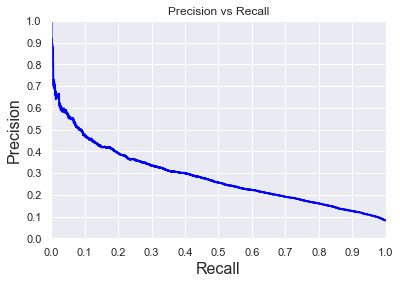

In [154]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Precision vs Recall')
    
plot_precision_vs_recall(precisions, recalls)

Looking at both plots, it seems that there's no sweet spot where there's a sharp decline in precision when fixing the recall at levels above 60%. The gradient of the precision curve below 40% is pretty stagnant. Now I'll just have to decide the level of recall I want.

In [89]:
thresh_recall_75 = thresholds[np.argmin(recalls >= 0.75)]
thresh_recall_75

0.43559812764049394

We should set the threshold around 0.435 for a 75% recall. Now let's see our new precision, recall, and confusion matrix.

In [90]:
y_pred = (y_pred_proba[:, 1] >= thresh_recall_75).astype('int')
print(f"""Precision: {precision_score(y_test, y_pred)}
Recall: {recall_score(y_test, y_pred)}

Confusion Matrix: 

{confusion_matrix(y_test, y_pred)}""")

Precision: 0.17566482452411317
Recall: 0.7497983870967742

Confusion Matrix: 

[[38999 17452]
 [ 1241  3719]]


## Hyperparameter optimization

My preferred choice of hyperparameter optimization is something called Bayesian hyperparameter optimization. It's been shown to outperform the more common methods which are gridsearch and randomsearch in terms of score and in times can be slightly faster than both of them.

The preparation is simple: I created 5 stratified folds out of the training the dataset to avoid overfitting, then I create an objective function that takes a set of parameters from the bigger function that does the optimization. This function returns the mean of 5 scores (one score for each fold) that will be minimized by the optimization algorithm. The last thing needed is defining a search space for each hyperparameter you want to optimize. That is all that's needed to run the algorithm.

There are a few libraries that can be used for the hyperparameter optimization, but for this instance I choose hyperopt.

In [ ]:
X_upcast = upcast_dtypes(X)
y_upcast = y.astype('float32')

del df, df_bur_bal, train, X, df_prev, X_train, df_prev_mrg, df_main, df_bur, df_bur_mrg, df_main_rest, df_main_compact, test, X_test; gc.collect()


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

In [31]:
def obj(params, folds=folds):
    
    print('============================================ Beginning Trial ============================================')
    params = {
        'iterations': 10000,
        'task_type': 'GPU',
        'random_state': 22,
        'class_weights': [0.1, 1],
        'boosting_type': 'Plain',
        'gpu_ram_part': 0.9,
        'learning_rate': float(params['learning_rate']),
        'depth': int(params['depth']),
        'l2_leaf_reg': int(params['depth']),
        'border_count': int(params['border_count'])
    }
    
    print(f'Parameters:\n {params}\n\n')
    scores = []

    for fold, (train_index, test_index) in enumerate(folds.split(X_upcast, y_upcast)):
        print(f'====================== Fitting fold {fold+1} ======================')
        X_train, y_train = X_upcast.iloc[train_index], y_upcast.iloc[train_index]
        X_test, y_test = X_upcast.iloc[test_index], y_upcast.iloc[test_index]
        clf = catboost.CatBoostClassifier(**params)
        clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=1000, verbose=5000)
        fold_score = clf.best_score_['validation']['Logloss']
        scores.append(fold_score)
    score = np.mean(scores)
    print(f'========================================= Trial score: {round(score, 6)} =========================================\n\n')
    return score

In [ ]:
search = {
        'depth': hp.uniform("depth", 5, 8),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -4.8, -4.5),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 10),
       }
trials = Trials()

rstate = np.random.RandomState(22)

best = fmin(fn=obj, space=search, algo=tpe.suggest, max_evals=10, rstate=rstate, trials=trials)

This cell outputs a very long log of the hyperparameter of the optimization process, so I cleared the output after running it. You can see the log here if you want: https://pastebin.com/YAc8DKRb

In [47]:
best

{'border_count': 82.20458019637348,
 'depth': 5.0779116539108315,
 'l2_leaf_reg': 9.501445816078585,
 'learning_rate': 0.00932263221287263}

In [57]:
results = [[i['tid'] + 1,
           i['result']['loss'], 
           i['misc']['vals']['border_count'][0], 
           i['misc']['vals']['depth'][0], 
           i['misc']['vals']['l2_leaf_reg'][0], 
           i['misc']['vals']['learning_rate'][0]] for i in trials.trials]
results.append(['best', 0.5528303257003708, best['border_count'], best['depth'], best['l2_leaf_reg'], best['learning_rate']])
results_df = pd.DataFrame(results, columns=['Trial ID', 'Loss ↓', 'border_count', 'depth', 'l2_leaf_reg','learning_rate'])
results_df.sort_values('Loss ↓')

Trial ID    Loss ↓  border_count     depth  l2_leaf_reg  learning_rate
5         6  0.552723     82.204580  5.077912     9.501446       0.009323
4         5  0.552780     61.773348  5.593137     7.360049       0.010743
10     best  0.552830     82.204580  5.077912     9.501446       0.009323
3         4  0.552884     45.922797  5.701304     8.990523       0.008467
9        10  0.552898    251.905580  6.596080     3.260025       0.009473
0         1  0.552911    105.330168  5.474784     3.339116       0.010941
6         7  0.553173    130.862180  6.007367     5.756770       0.008445
2         3  0.553184    190.689283  6.984169     4.749253       0.008817
8         9  0.554098     75.067273  7.028667     4.172883       0.008377
7         8  0.554247     60.264662  7.484515     7.535062       0.010118
1         2  0.554296     91.974839  7.801798     7.272595       0.009180

In [70]:
best_params = {
        'iterations': 20000,
        'task_type': 'GPU',
        'random_state': 22,
        'class_weights': [0.1, 1],
        'boosting_type': 'Plain',
        'gpu_ram_part': 0.9
    }

best_params['border_count'] = int(results[3][2])
best_params['depth'] = int(results[3][3])
best_params['l2_leaf_reg'] = int(results[3][4])
best_params['learning_rate'] = results[3][5]

In [71]:
X_train = upcast_dtypes(X_train)
X_test = upcast_dtypes(X_test)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

clf = catboost.CatBoostClassifier(**best_params)
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=1000, verbose=5000)

0:	learn: 0.6919405	test: 0.6919690	best: 0.6919690 (0)	total: 29.6ms	remaining: 9m 52s
5000:	learn: 0.5172346	test: 0.5547092	best: 0.5546946 (4985)	total: 2m 17s	remaining: 6m 53s
bestTest = 0.5530651478
bestIteration = 8770
Shrink model to first 8771 iterations.


In [87]:
y_pred_proba = clf.predict_proba(X_test)

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
thresh_recall_75 = thresholds[np.argmin(recalls >= 0.75)]
y_pred = (y_pred_proba[:, 1] >= thresh_recall_75).astype('int')

print(f"""Precision: {precision_score(y_test, y_pred)}
Recall: {recall_score(y_test, y_pred)}
ROC: {roc_auc_score(y_test, y_pred)}

Confusion Matrix: 

{confusion_matrix(y_test, y_pred)}""")

Precision: 0.17644826113773307
Recall: 0.7497983870967742
ROC: 0.7211552386140192

Confusion Matrix: 

[[39093 17358]
 [ 1241  3719]]


This is good. Previously, to have a 75% recall, we have to settle with 17.56% precision. Now we can achieve the same level of recall with a precision level of 17.64%, a modest increase but an increase nonetheless.

# Feature importance & Simple Feature Selection

I know that the proper method of doing feature selection is NOT after doing lengthy hyperparameter optimization. Commonly a model is fit on the whole dataset after preprocessing it and you plot feature importance or do any other method of feature selection after that, then remove the features or create new features out of the important features before fitting the model again.

I just think this workflow works for my purposes now, which is to showcase my key skills in handling an end-to-end machine learning project.

In [92]:
D_train = catboost.Pool(X_train, y_train)
feat_imp = clf.get_feature_importance(D_train, thread_count=-1, prettified=True)

In [110]:
feat_imp

Feature Id  Importances
0                          EXT_SOURCE_3     9.517944
1                          EXT_SOURCE_2     7.414411
2                        ANNUITY/CREDIT     2.900886
3                            DAYS_BIRTH     2.364632
4                          EXT_SOURCE_1     2.102409
..                                  ...          ...
691   CCB_NAME_CONTRACT_STATUS_nan_mean     0.000000
692  CCB_AMT_DRAWINGS_OTHER_CURRENT_min     0.000000
693  CCB_CNT_DRAWINGS_OTHER_CURRENT_min     0.000000
694                      CCB_SK_DPD_min     0.000000
695                  CCB_SK_DPD_DEF_min     0.000000

[696 rows x 2 columns]

In [94]:
feat_imp[feat_imp['Importances'] == 0].shape[0]

63

63 features are esentially useless for the model.

In [112]:
drop_features = feat_imp[feat_imp['Importances'] < 0.1]['Feature Id'].values.tolist()
len(drop_features)

500

500 features (this includes the previous 63 with 0 feature importance) have feature importance lower than 0.1. To put it into perspective, the preprocessed dataset have 696 features. It's possible that dropping that very large chunk of the dataset might considerably improve training and prediction time without significantly impacting the predictive capability.

Before doing that, I want to plot the features that are left out.

Text(0.5, 1.0, 'Top 100 Features based on Feature Importance')

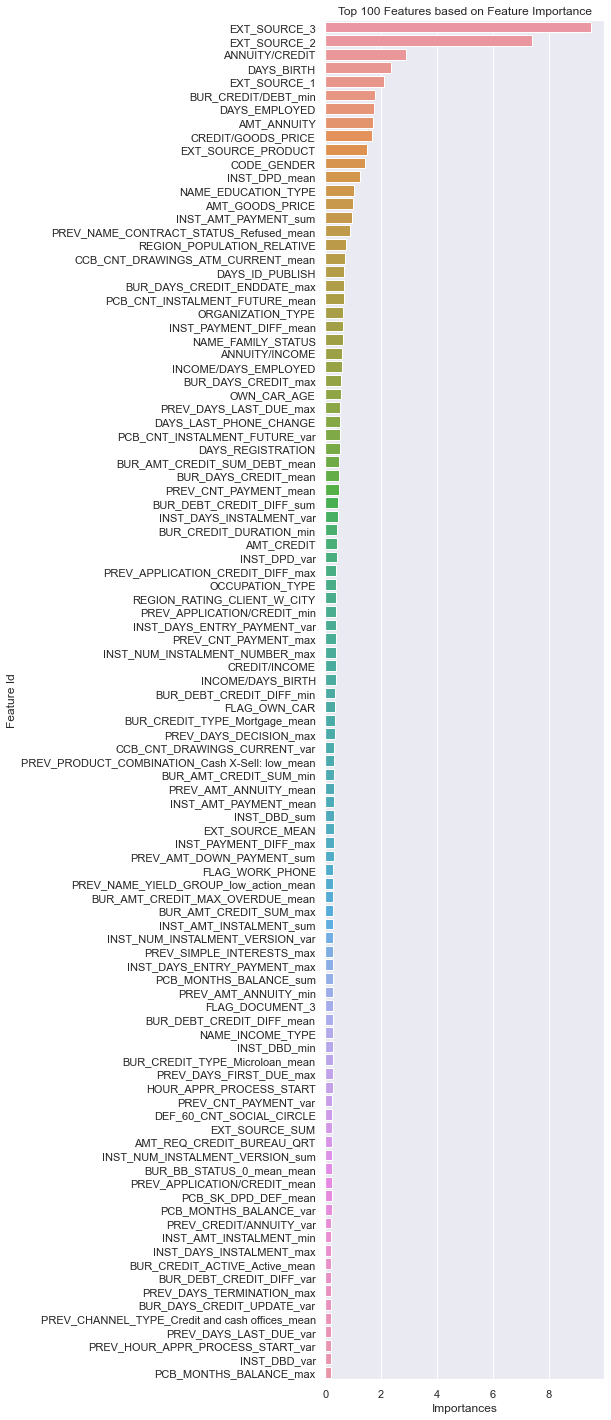

In [129]:
feat_imp_compact = feat_imp[feat_imp['Importances'] >= 0.1]
fig, ax = plt.subplots(figsize=(5, 25))
plt.grid(True)
sns.barplot(data=feat_imp_compact.sort_values(by='Importances', ascending=False).iloc[:100], y='Feature Id', x='Importances')
plt.title('Top 100 Features based on Feature Importance')

In [124]:
%%time

X_train_compact = X_train[[i for i in X_train.columns if i not in drop_features]]
X_test_compact = X_test[[i for i in X_test.columns if i not in drop_features]]

__clf = catboost.CatBoostClassifier(**best_params)
__clf.fit(X_train_compact, y_train, eval_set=[(X_test_compact, y_test)], early_stopping_rounds=1000, verbose=5000)

0:	learn: 0.6919319	test: 0.6919603	best: 0.6919603 (0)	total: 18.6ms	remaining: 6m 12s
5000:	learn: 0.5161164	test: 0.5544425	best: 0.5544362 (4984)	total: 1m 27s	remaining: 4m 22s
bestTest = 0.5528011884
bestIteration = 8556
Shrink model to first 8557 iterations.
Wall time: 2min 50s


The training time is significantly shorter now with those 500 features removed. Now let's look at the metrics.

In [125]:
y_pred_proba = __clf.predict_proba(X_test_compact)

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
thresh_recall_75 = thresholds[np.argmin(recalls >= 0.75)]
y_pred = (y_pred_proba[:, 1] >= thresh_recall_75).astype('int')

print(f"""Precision: {precision_score(y_test, y_pred)}
Recall: {recall_score(y_test, y_pred)}
ROC: {roc_auc_score(y_test, y_pred)}

Confusion Matrix: 

{confusion_matrix(y_test, y_pred)}""")

Precision: 0.1750776763016665
Recall: 0.7497983870967742
ROC: 0.7196937941754796

Confusion Matrix: 

[[38928 17523]
 [ 1241  3719]]


The scores are virtually the same before and after removing the features. That's a very good tradeoff between a huge increase in training and prediction time and slight decrease in the scores.